In [2]:
from astropy.table import Table
from sklearn import neighbors
import numpy as np
import sys
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
from scipy import stats
import pickle
from astropy.io import fits
import random
from astropy.io import ascii
from scipy.integrate import quad
from sklearn.neighbors import NearestNeighbors

# np.set_printoptions(threshold=sys.maxsize)

## Data

In [3]:
data = Table.read('data_flags_updated_Nov1.dat', format = 'ascii')
catalog =data
ra_boolean = np.logical_and(catalog['ra'] > 110, catalog['ra'] < 270)
catalog_north = catalog[ra_boolean]
strip_boolean = np.logical_and.reduce([catalog_north['ra'] > 250, 
                                       catalog_north['ra'] < 269, 
                                       catalog_north['dec'] > 51, 
                                       catalog_north['dec'] < 67])
catalog_main = catalog_north[~strip_boolean]
data = catalog_main

In [4]:
# ra,dec,z
ra = np.array(data['ra'])
dec = np.array(data['dec'])
z = np.array(data['redshift'])

#stellar mass
Mstar = np.array(data['Mstar'])
# Mstar = Mstar[np.logical_not(np.isnan(Mstar))] 
Mstar_NSA= np.array(data['Mstar_NSA'])
# color
u_r = np.array(data['u_r'])
# u_r = u_r[np.logical_not(np.isnan(u_r))] 

g_r = np.array(data['g_r'])
# g_r = g_r[np.logical_not(np.isnan(g_r))] 

# u_r_NSA = np.array(data['u_r_NSA'])
# g_r_NSA = np.array(data['g_r_NSA'])
# absolute magniture
rabsmag = np.array(data['rabsmag'])
# rabsmag = rabsmag[np.logical_not(np.isnan(rabsmag))] 

rabsmag_NSA = np.array(data['rabsmag_NSA'])
#star formation rate and specific SPR
SFR  = np.array(data['SFR'])
# SFR = SFR[np.logical_not(np.isnan(SFR))] 

sSFR = np.array(data['sSFR'])
# sSFR = sSFR[np.logical_not(np.isnan(sSFR))] 

#classification V^2

wall_v2 = np.argwhere(data['flag_vsquared'] == 0).flatten()
void_v2 = np.argwhere(data['flag_vsquared'] == 1).flatten()
edge_v2 = np.argwhere(data['flag_vsquared'] == 2).flatten()
out_v2 = np.argwhere(data['flag_vsquared'] == 9).flatten()

#classification voidfinder

wall_vf = np.argwhere(data['flag_voidfinder'] == 0).flatten()
void_vf = np.argwhere(data['flag_voidfinder'] == 1).flatten()
edge_vf = np.argwhere(data['flag_voidfinder'] == 2).flatten()
out_vf = np.argwhere(data['flag_voidfinder'] == 9).flatten()

# len(wall_v2)+len(void_v2)+len(edge_v2)+len(out_v2),len(wall_vf)+len(void_vf)+len(edge_vf)+len(out_vf), len(data) #check

In [5]:
all_survey = data[data['redshift']< 0.1026]  # galaxies within the redshift cut

glx_excess= np.logical_and(all_survey['rabsmag']>-18.2,all_survey['rabsmag']<-16.8)

wall_vf_excess = np.logical_and(np.logical_and(all_survey['rabsmag']>-18.2,all_survey['rabsmag']<-16.8), all_survey['flag_voidfinder'] == 0)
# void_vf_excess = np.logical_and(np.logical_and(all_survey['rabsmag']>-18.2,all_survey['rabsmag']<-16.8), all_survey['flag_voidfinder'] == 1)
wall_v2_range = np.logical_and(np.logical_and(all_survey['rabsmag']>b,all_survey['rabsmag']<a), all_survey['flag_vsquared'] == 0)
    
wall_v2_excess = np.logical_and(np.logical_and(all_survey['rabsmag']>-18.2,all_survey['rabsmag']<-16.8), all_survey['flag_vsquared'] == 0)
void_v2_excess = np.logical_and(np.logical_and(all_survey['rabsmag']>-18.2,all_survey['rabsmag']<-16.8), all_survey['flag_vsquared'] == 1)
    
wall_v2_bool= (all_survey['flag_vsquared'] == 0)

NameError: name 'b' is not defined

Nearest Neighbours

In [ ]:
# wall_v2_range = np.logical_and(np.logical_and(all_survey['rabsmag']>b,all_survey['rabsmag']<a), all_survey['flag_vsquared'] == 0)
#     void_v2_rand = np.logical_and(np.logical_and(all_survey['rabsmag']>b,all_survey['rabsmag']<a), all_survey['flag_vsquared'] == 1)
galaxy_table_wall_v2=all_survey[wall_v2_bool]
galaxy_table_wall_v2_xyz=ra_dec_z_to_xyz(galaxy_table_wall_v2)

X1 = galaxy_table_wall_v2_xyz
Y1= galaxy_table_wall_v2_xyz
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X1)
distances, indices = nbrs.kneighbors(Y1)
distances_wall_v2=distances[:,1]


In [ ]:
plt.figure(figsize=(12,7))

plt.scatter(all_survey[wall_v2_bool]['rabsmag'],distances_wall_v2,alpha=0.1, s=1, color="g") # void vf
plt.ylim(0,12)
plt.xlim(-10,-24)
plt.xlabel("absolute magnitude", fontsize=14)
plt.title("WALL V2")
plt.ylabel("distance to nearest neighbor", fontsize=14)
plt.show()# the deeper objects are brighter

In [22]:
# ## x y z radius flag r ra dec
# maximal_=np.loadtxt('ALL_comoving_maximal.txt')

In [29]:
# ra_maximal=maximal_[:,6]
# dec_maximal=maximal_[:,7]
# r_maximal=maximal_[:,5]

In [39]:
# c = 299792
# def f(a,omega_m):
#      return 1/(np.sqrt(a*omega_m*(1+((1-omega_m)*a**3/omega_m))))

# def Distance(z,omega_m,h):
#     dist = np.ones(len(z))
#     H0 = 100*h
#     for i,redshift in enumerate(z):
#         a_start = 1/(1+redshift)
#         I = quad(f,a_start,1,args=omega_m)
#         dist[i] = I[0]*(c/H0)
#     return dist

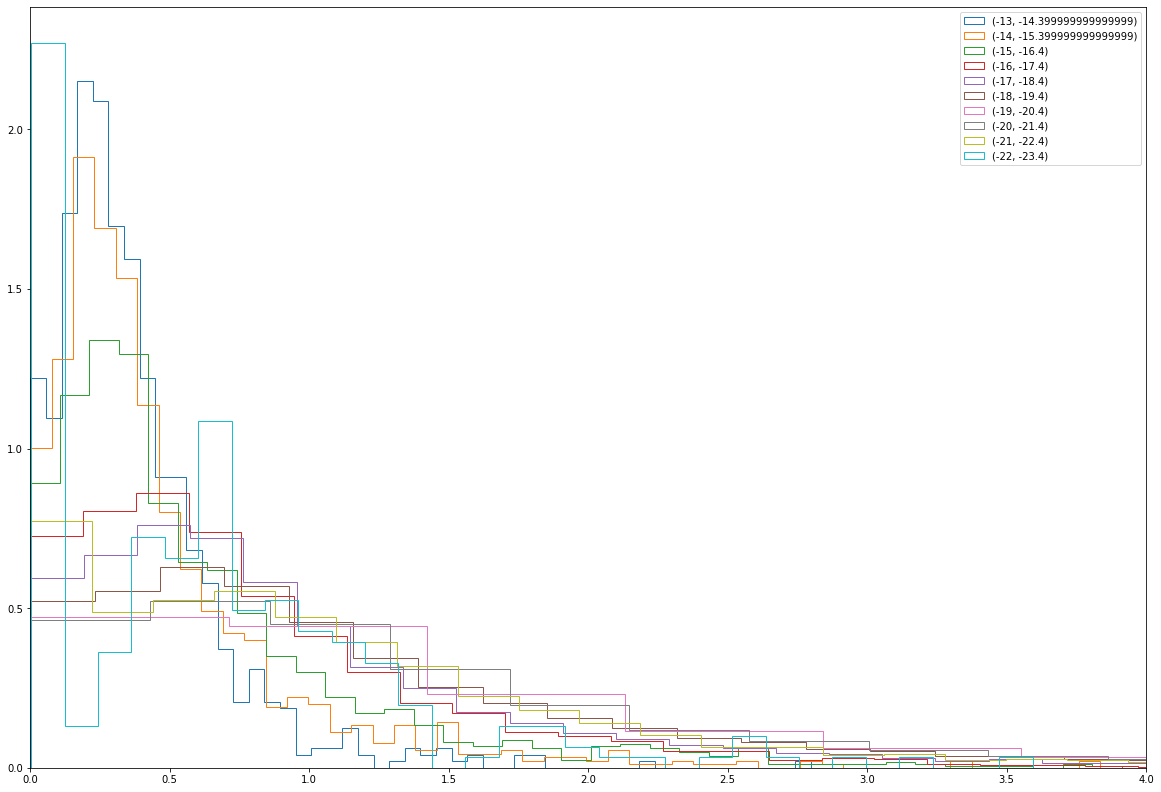

In [13]:
a_=[]
b_=[]
for i in [-13,-14,-15,-16,-17,-18,-19,-20,-21,-22]:
    a = i#np.random.uniform(-22+(18.2-16.8),-16+(18.2-16.8))
    b = a-(18.2-16.8)
    a_.append(a)
    b_.append(b)
    
#     wall_vf_rand = np.logical_and(np.logical_and(all_survey['rabsmag']>b,all_survey['rabsmag']<a), all_survey['flag_voidfinder'] == 0)
#     void_vf_rand = np.logical_and(np.logical_and(all_survey['rabsmag']>b,all_survey['rabsmag']<a), all_survey['flag_voidfinder'] == 1)
def range_neig(a,b):
    wall_v2_range = np.logical_and(np.logical_and(all_survey['rabsmag']>b,all_survey['rabsmag']<a), all_survey['flag_vsquared'] == 0)
#     void_v2_rand = np.logical_and(np.logical_and(all_survey['rabsmag']>b,all_survey['rabsmag']<a), all_survey['flag_vsquared'] == 1)
    galaxy_table_range_wall_v2=all_survey[wall_v2_range]
    galaxy_table_range_wall_v2_xyz=ra_dec_z_to_xyz(galaxy_table_range_wall_v2)
    
    X1 = galaxy_table_wall_v2_xyz # all wall galaxies
    Y1= galaxy_table_range_wall_v2_xyz 
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X1)
    distances, indices = nbrs.kneighbors(Y1)
    distances_range=distances[:,1]
    return distances_range

plt.figure(figsize=(20,14))
for i in range(len(a_)):
    plt.hist(range_neig(a_[i],b_[i]), bins=50, density=True, label=str((a_[i],b_[i])), histtype='step')
# plt.hist(range_neig(a_[-1],b_[-1]), bins=200, density=True, label=str((a,b)), histtype='step')
# plt.hist(distances_range, bins=500, density=True, label=str((a,b)), histtype='step')
# plt.hist(distances_range, bins=500, density=True, label=str((a,b)), histtype='step')
# plt.hist(distances_range, bins=500, density=True, label=str((a,b)), histtype='step')
# plt.hist(distances_range, bins=500, density=True, label=str((a,b)), histtype='step')
# plt.hist(distances_range, bins=500, density=True, label=str((a,b)), histtype='step')
# plt.hist(distances_range, bins=500, density=True, label=str((a,b)), histtype='step')
# plt.hist(distances_range, bins=500, density=True, label=str((a,b)), histtype='step')
#     plt.hist(distances_excess, bins=100,density=True, alpha=0.5, label="excess")
plt.xlim(0,4)
plt.legend()
plt.show()

#     plt.scatter(np.array(all_survey[void_v2_rand]['ra']),np.array(all_survey[void_v2_rand]['dec']))
#     plt.title(str((a,b))+"  V2 void" )
#     plt.xlabel("ra")
#     plt.ylabel("dec")
# #     plt.xlim(-10,370)
# #     plt.ylim(-30,85)
#     plt.show()
#     plt.hist(np.array(all_survey[void_v2_rand]['redshift']))
# #     plt.xlim(0,0.1026)
#     plt.xlabel("redshift"+str((a,b)))
#     plt.ylabel("count")
#     plt.show()
    

In [3]:
# ind_gal_depth_voidv2_new = np.load('galaxy_in_maximal_indices', allow_pickle=True)

### Bump depths

In [2]:
ind_gal_depth_voidv2_new = np.load('ind_gal_depth_voidv2_equal_slices.npy', allow_pickle=True)

In [42]:
np.sum(wall_v2_bool), np.sum(wall_v2_excess)

(217131, 11087)

### Save excess range for visualization

In [103]:
ra_excess=np.array(all_survey[wall_v2_bool]['ra'])
redshift_excess=np.array(all_survey[wall_v2_bool]['redshift'])
dec_excess=np.array(all_survey[wall_v2_bool]['dec'])
Rgal_excess=np.array(all_survey[wall_v2_bool]['Rgal'])
rabsmag_excess=np.array(all_survey[wall_v2_bool]['rabsmag'])

In [104]:
galaxies_excess_table = Table([ra_excess,dec_excess,redshift_excess,Rgal_excess,rabsmag_excess], names=('ra','dec','redshift','Rgal','rabsmag'))
ascii.write(galaxies_excess_table, 'wall_v2_bool.dat',format='commented_header', overwrite=True)  

### nearest distance of excess range

In [15]:
galaxy_table_excess_wall_v2=all_survey[wall_v2_excess]
galaxy_table_wall_v2=all_survey[wall_v2_bool]
galaxy_table_range_wall_v2=all_survey[wall_v2_range]

NameError: name 'wall_v2_range' is not defined

In [8]:
def ra_dec_z_to_xyz(galaxy_table):
    h=1
    DtoR = np.pi/180.
    RtoD = 180./np.pi
    c = 3e5

    r_gal = c*galaxy_table['redshift'].data/(100*h)
    ra = galaxy_table['ra'].data
    dec = galaxy_table['dec'].data
    
    ra_radian = ra*DtoR

    dec_radian = dec*DtoR

    x_gal = r_gal*np.cos(ra_radian)*np.cos(dec_radian)

    y_gal = r_gal*np.sin(ra_radian)*np.cos(dec_radian)

    z_gal = r_gal*np.sin(dec_radian)

    num_gal = x_gal.shape[0]

    gals_xyz = np.concatenate((x_gal.reshape(num_gal,1),
                                     y_gal.reshape(num_gal,1),
                                     z_gal.reshape(num_gal,1)), axis=1)
    return gals_xyz

In [14]:
galaxy_table_excess_wall_v2_xyz=ra_dec_z_to_xyz(galaxy_table_excess_wall_v2)
galaxy_table_wall_v2_xyz=ra_dec_z_to_xyz(galaxy_table_wall_v2)
galaxy_table_range_wall_v2_xyz=ra_dec_z_to_xyz(galaxy_table_range_wall_v2)


NameError: name 'galaxy_table_range_wall_v2' is not defined

In [126]:
# tree = neighbors.KDTree(gals_xyz, metric = 'euclidean')
# ind =  tree.query_radius(gals_xyz_all, r =i*radius_voidv2)

In [12]:
X1 = galaxy_table_wall_v2_xyz # all wall galaxies
Y1= galaxy_table_range_wall_v2_xyz 
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X1)
distances, indices = nbrs.kneighbors(Y1)
distances_range=distances[:,1]

NameError: name 'galaxy_table_range_wall_v2_xyz' is not defined

In [110]:
X = galaxy_table_wall_v2_xyz # all wall galaxies
Y= galaxy_table_excess_wall_v2_xyz # excess galaxies
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(Y)
distances_excess=distances[:,1]

array([[0.        , 0.57482199],
       [0.        , 2.32103337],
       [0.        , 0.59249902],
       ...,
       [0.        , 1.45412599],
       [0.        , 0.51755289],
       [0.        , 2.39035503]])

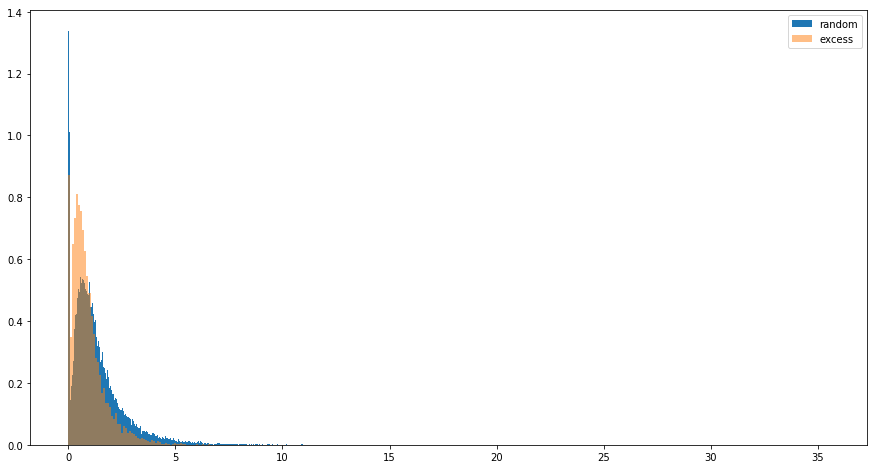

In [144]:
plt.figure(figsize=(15,8))
plt.hist(distances_range, bins=1000, density=True, label="random")
plt.hist(distances_excess, bins=100,density=True, alpha=0.5, label="excess")
plt.legend()
plt.show()

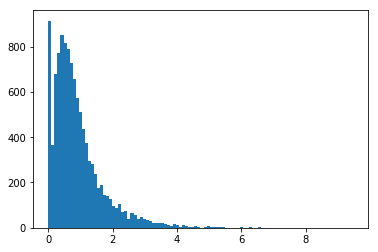

In [120]:
plt.show()

In [80]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
# this finds the the closest neighbours from X to Y and their distances.
X = [[0,0],[1,1]]
Y=[[0,2],[0,1],[5,0],[0.9,1],[1,1]] 
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(Y)
distances

array([[1.41421356],
       [1.        ],
       [4.12310563],
       [0.1       ],
       [0.        ]])

In [81]:
indices

array([[1],
       [0],
       [1],
       [1],
       [1]])

In [83]:
np.sqrt(17)

4.123105625617661

In [52]:
trial = [[0,0,0],[1,1,1]]
trial_test = [[0,0,2],[0,5,0],[5,1,0],[5,0,0]] 
trial = np.array(trial)
trial_test = np.array(trial_test)

tree = neighbors.KDTree(trial, metric = 'euclidean')
ind =  tree.query_radius(trial_test, r =5)
# print("distance to closest neighbour is: ", dist) # distance between entry of trial_test and closest neighbour in trial
print("index of closest neighbour", ind) # indices from trial that are within radius r of entry in trial_test

AttributeError: 'sklearn.neighbors._kd_tree.KDTree' object has no attribute 'NearestNeighbors'

### back to bump

In [11]:
hd = fits.open('galdepth10.fits', format='ascii')
new_depths = Table(hd[1].data) # depth_norm : 0 at the edge of a void to 1 at the deepest.
gal_depth = new_depths['GAL_ID'][(new_depths['DEPTH_NORM'] != -1)]
norm_depth = new_depths['DEPTH_NORM'][(new_depths['DEPTH_NORM'] != -1)]

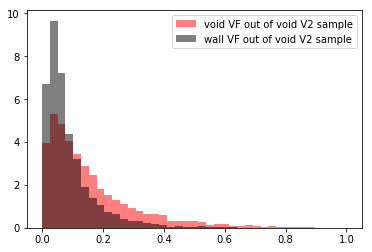

In [9]:
plt.hist(new_depths[data['redshift']< 0.1026]['DEPTH_NORM'][void_vf_excess],bins=np.linspace(0,1, 40), density=True, alpha = 0.5,color="red", label="void VF out of void V2 sample")
plt.hist(new_depths[data['redshift']< 0.1026]['DEPTH_NORM'][wall_vf_excess],bins=np.linspace(0,1, 40), density=True, alpha = 0.5,color="black", label="wall VF out of void V2 sample")
plt.legend()
plt.show()

#     ax.hist(bins_wall[:-1], bins=bins_wall, weights=counts_wall, label = 'Wall' , color=color_wall, histtype='step',linestyle=('dashed'))


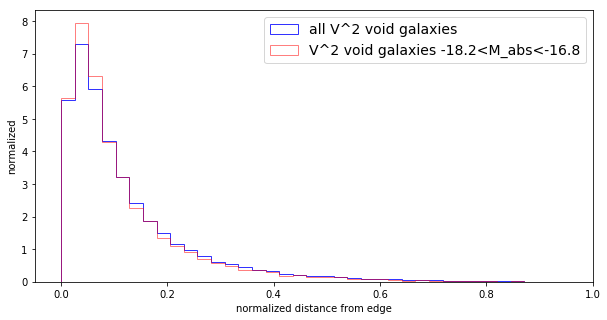

The x-axis is the closest distance from the position of the galaxy to
the edge of the void which is defined as all of the Voronoi cell 
edges that make up the boundary between a cell inside the void and
a cell outside of it. Thus, 0 is at the edge, 1 is at the center.
The distance to the edge of each galaxy is normalized by the largest 
distance to the edge in the host void.


In [10]:
plt.figure(figsize=(10,5))
plt.hist(new_depths[data['redshift']< 0.1026]['DEPTH_NORM'], bins=np.linspace(0,1, 40), density=True, label="all V^2 void galaxies", color='blue', alpha=0.8, histtype='step')
plt.hist(new_depths[data['redshift']< 0.1026]['DEPTH_NORM'][void_v2_excess], bins=np.linspace(0,1, 40), density=True, alpha = 0.5,color="red", label="V^2 void galaxies -18.2<M_abs<-16.8", histtype='step')
# plt.ylim(0,100000)

plt.xlabel("normalized distance from edge")
plt.ylabel("normalized")
plt.legend(fontsize=14)
plt.xlim(-0.05,1)
plt.show()
print("""The x-axis is the closest distance from the position of the galaxy to
the edge of the void which is defined as all of the Voronoi cell 
edges that make up the boundary between a cell inside the void and
a cell outside of it. Thus, 0 is at the edge, 1 is at the center.
The distance to the edge of each galaxy is normalized by the largest 
distance to the edge in the host void.""")



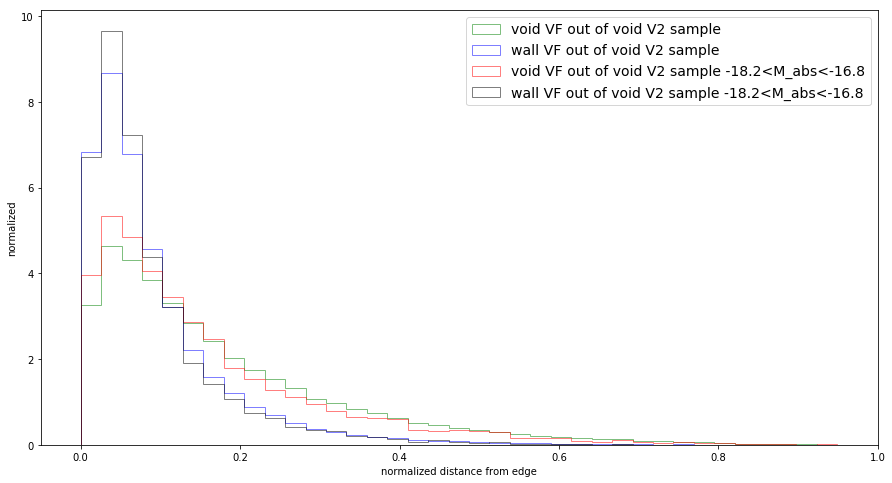

In [11]:
plt.figure(figsize=(15,8))

# plt.hist(new_depths[data['redshift']< 0.1026]['DEPTH_NORM'], bins=np.linspace(0,1, 40), density=True, label="all V^2 void galaxies", color='cyan', alpha=0.8, histtype='step')
# plt.hist(new_depths[data['redshift']< 0.1026]['DEPTH_NORM'][void_v2_excess], bins=np.linspace(0,1, 40), density=True, alpha = 0.5,color="orange", label="V^2 void galaxies -18.2<M_abs<-16.8", histtype='step')

plt.hist(new_depths[data['redshift']< 0.1026]['DEPTH_NORM'][all_survey['flag_voidfinder'] == 1],bins=np.linspace(0,1, 40), density=True, alpha = 0.5,color="green", label="void VF out of void V2 sample",histtype='step')
plt.hist(new_depths[data['redshift']< 0.1026]['DEPTH_NORM'][all_survey['flag_voidfinder'] == 0],bins=np.linspace(0,1, 40), density=True, alpha = 0.5,color="blue", label="wall VF out of void V2 sample",histtype='step')

plt.hist(new_depths[data['redshift']< 0.1026]['DEPTH_NORM'][void_vf_excess],bins=np.linspace(0,1, 40), density=True, alpha = 0.5,color="red", label="void VF out of void V2 sample -18.2<M_abs<-16.8",histtype='step')
plt.hist(new_depths[data['redshift']< 0.1026]['DEPTH_NORM'][wall_vf_excess],bins=np.linspace(0,1, 40), density=True, alpha = 0.5,color="black", label="wall VF out of void V2 sample -18.2<M_abs<-16.8",histtype='step')
# plt.ylim(0,100000)

plt.xlabel("normalized distance from edge")
plt.ylabel("normalized")
plt.legend(fontsize=14)
plt.xlim(-0.05,1)
plt.show()




In [ ]:
plt.figure(figsize=(15,8))

# plt.hist(new_depths[data['redshift']< 0.1026]['DEPTH_NORM'], bins=np.linspace(0,1, 40), density=True, label="all V^2 void galaxies", color='cyan', alpha=0.8, histtype='step')
plt.hist(new_depths[data['redshift']< 0.1026]['DEPTH_NORM'][void_v2_excess], bins=np.linspace(0,1, 40), density=True, alpha = 0.5,color="orange", label="V^2 void galaxies -18.2<M_abs<-16.8", histtype='step')

plt.hist(new_depths[data['redshift']< 0.1026]['DEPTH_NORM'][all_survey['flag_voidfinder'] == 1],bins=np.linspace(0,1, 40), density=True, alpha = 0.5,color="green", label="void VF out of void V2 sample",histtype='step')
plt.hist(new_depths[data['redshift']< 0.1026]['DEPTH_NORM'][all_survey['flag_voidfinder'] == 0],bins=np.linspace(0,1, 40), density=True, alpha = 0.5,color="blue", label="wall VF out of void V2 sample",histtype='step')

plt.hist(new_depths[data['redshift']< 0.1026]['DEPTH_NORM'][void_vf_excess],bins=np.linspace(0,1, 40), density=True, alpha = 0.5,color="red", label="void VF out of void V2 sample -18.2<M_abs<-16.8",histtype='step')
# plt.hist(new_depths[data['redshift']< 0.1026]['DEPTH_NORM'][wall_vf_excess],bins=np.linspace(0,1, 40), density=True, alpha = 0.5,color="black", label="wall VF out of void V2 sample -18.2<M_abs<-16.8",histtype='step')
# plt.ylim(0,100000)

plt.xlabel("normalized distance from edge")
plt.ylabel("normalized")
plt.legend(fontsize=14)
plt.xlim(-0.05,1)
plt.show()




In [ ]:
# plt.figure(figsize=(15,8))

# plt.hist(new_depths[data['redshift']< 0.1026]['DEPTH_NORM'], bins=np.linspace(0,1, 40), density=True, label="all V^2 void galaxies", color='cyan', alpha=0.8, histtype='step')
# plt.hist(new_depths[data['redshift']< 0.1026]['DEPTH_NORM'][void_v2_excess], bins=np.linspace(0,1, 40), density=True, alpha = 0.5,color="orange", label="V^2 void galaxies -18.2<M_abs<-16.8", histtype='step')

# # plt.hist(new_depths[data['redshift']< 0.1026]['DEPTH_NORM'][all_survey['flag_voidfinder'] == 1],bins=np.linspace(0,1, 40), density=True, alpha = 0.5,color="green", label="void VF out of void V2 sample",histtype='step')
# # plt.hist(new_depths[data['redshift']< 0.1026]['DEPTH_NORM'][all_survey['flag_voidfinder'] == 0],bins=np.linspace(0,1, 40), density=True, alpha = 0.5,color="blue", label="wall VF out of void V2 sample",histtype='step')

# plt.hist(new_depths[data['redshift']< 0.1026]['DEPTH_NORM'][void_vf_excess],bins=np.linspace(0,1, 40), density=True, alpha = 0.1,color="red", label="void VF out of void V2 sample -18.2<M_abs<-16.8")
# plt.hist(new_depths[data['redshift']< 0.1026]['DEPTH_NORM'][wall_vf_excess],bins=np.linspace(0,1, 40), density=True, alpha = 0.2,color="black", label="wall VF out of void V2 sample -18.2<M_abs<-16.8")
# # plt.ylim(0,100000)

# plt.xlabel("normalized distance from edge")
# plt.ylabel("normalized")
# plt.legend(fontsize=14)
# plt.xlim(-0.05,1)
# plt.show()

In [190]:
print("both v2 voids are in the middle. void VF tend away from the edge and void wall tend towards the edge as expected")

both v2 voids are in the middle. void VF tend away from the edge and void wall tend towards the edge as expected


In [ ]:
['Mstar']

-13 -14.399999999999999


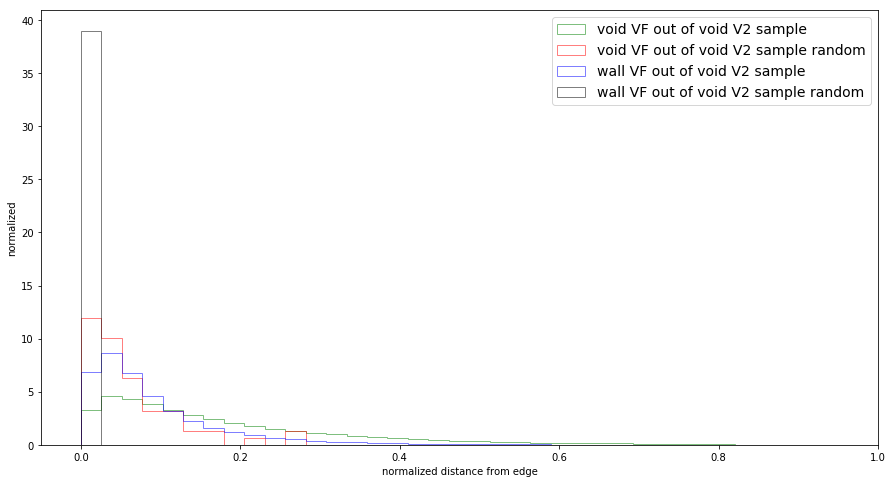

-14 -15.399999999999999


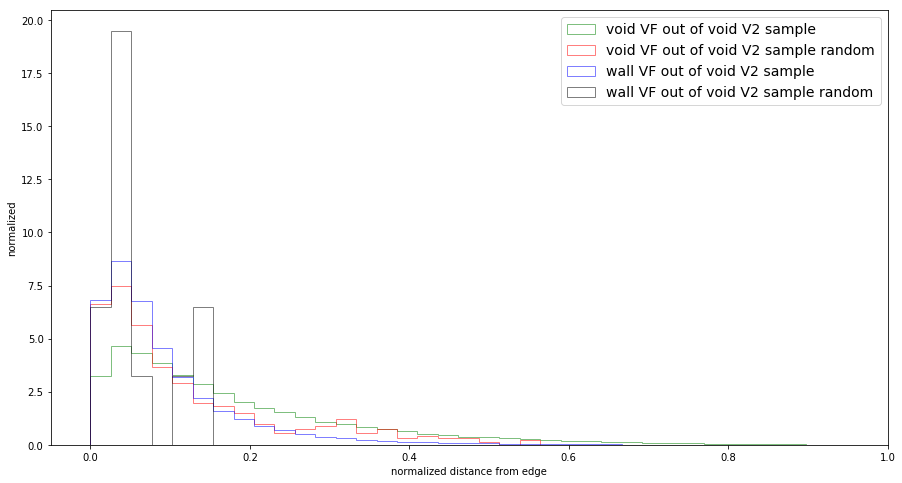

-15 -16.4


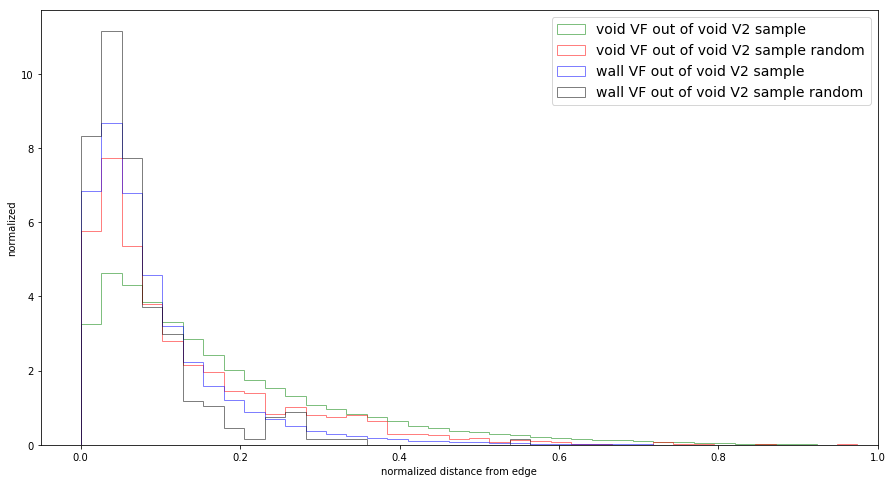

-16 -17.4


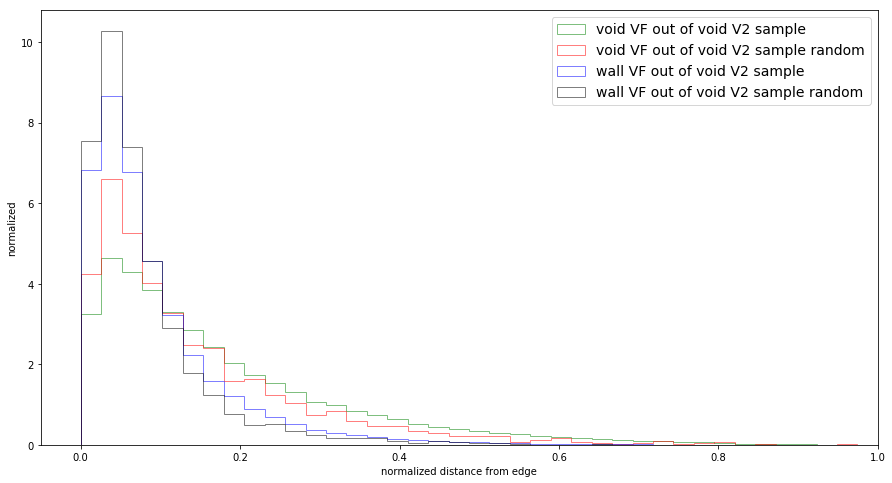

-17 -18.4


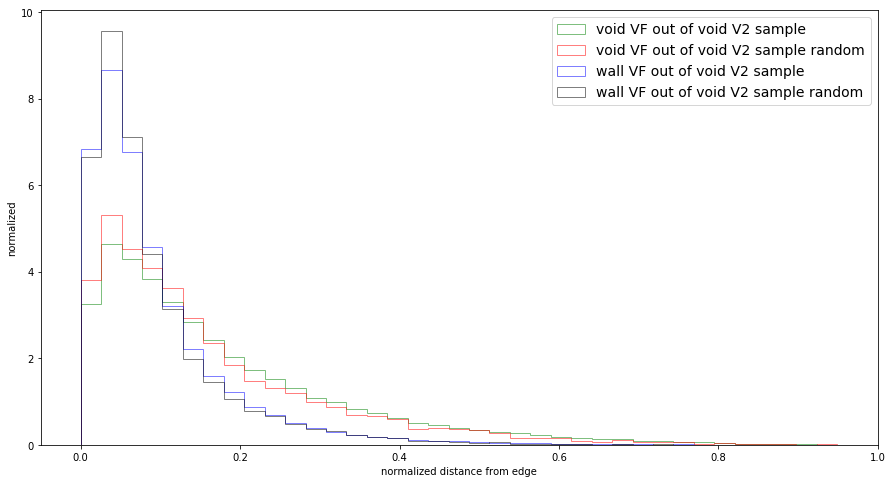

-18 -19.4


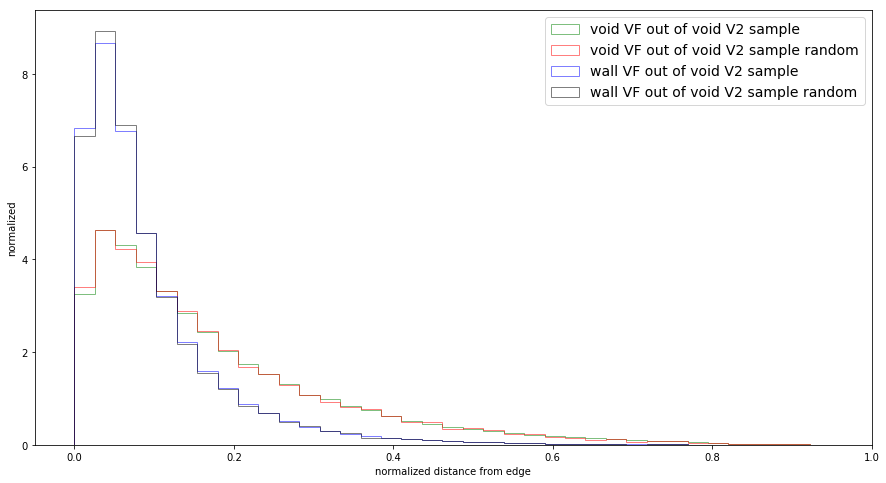

-19 -20.4


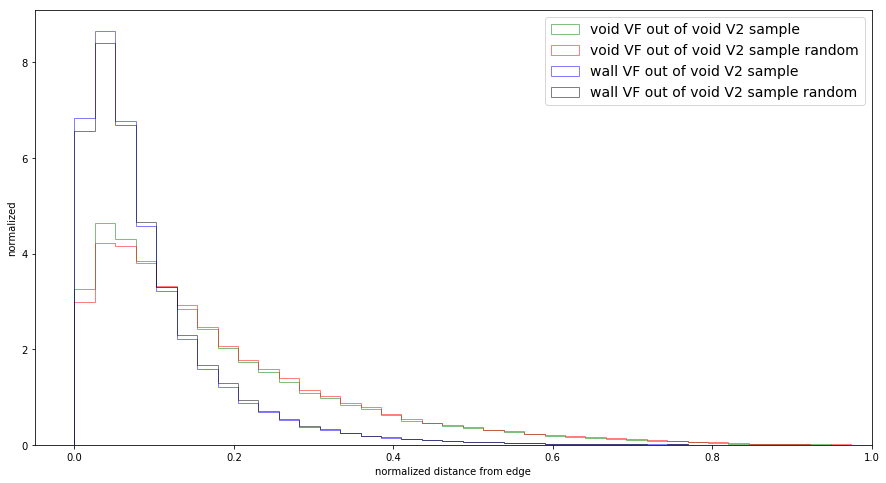

-20 -21.4


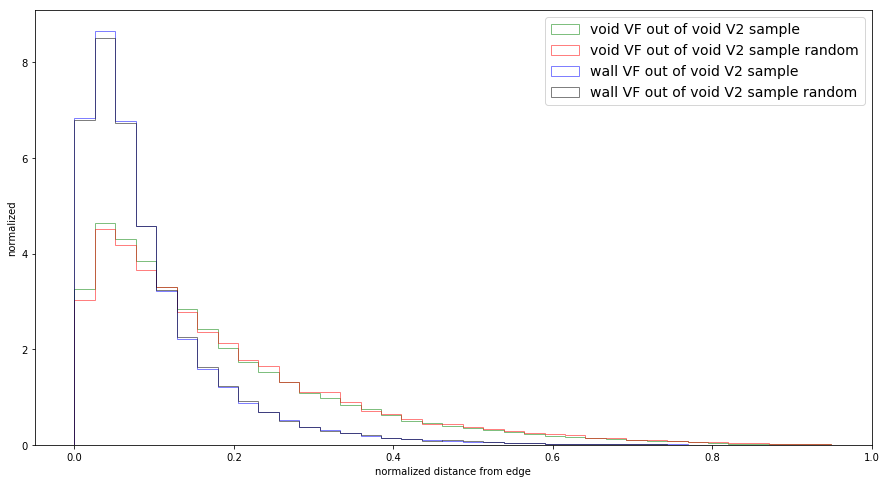

-21 -22.4


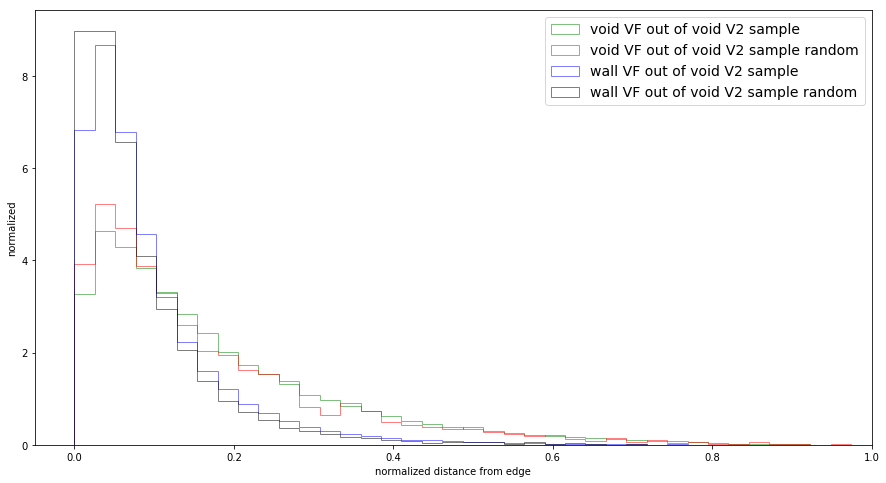

-22 -23.4


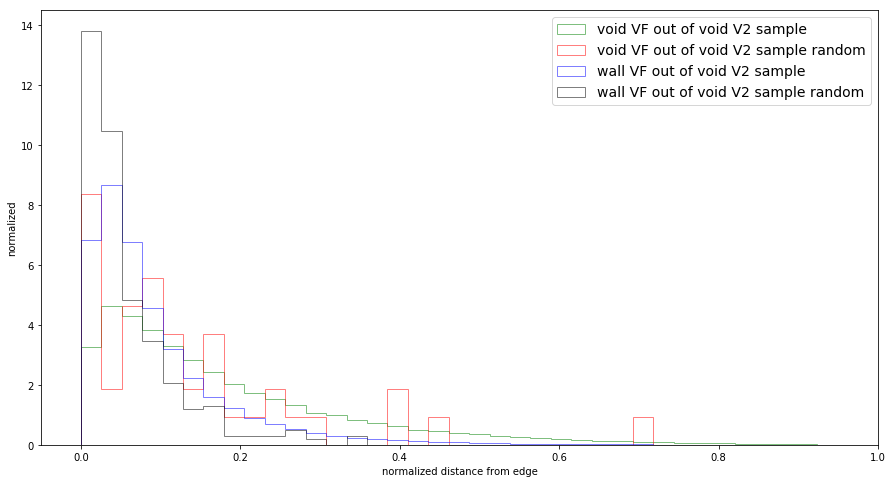

In [54]:
for i in [-13,-14,-15,-16,-17,-18,-19,-20,-21,-22]:
    a = i#np.random.uniform(-22+(18.2-16.8),-16+(18.2-16.8))
    b = a-(18.2-16.8)
    print(a,b)

    wall_vf_rand = np.logical_and(np.logical_and(all_survey['rabsmag']>b,all_survey['rabsmag']<a), all_survey['flag_voidfinder'] == 0)
    void_vf_rand = np.logical_and(np.logical_and(all_survey['rabsmag']>b,all_survey['rabsmag']<a), all_survey['flag_voidfinder'] == 1)

    wall_v2_rand = np.logical_and(np.logical_and(all_survey['rabsmag']>b,all_survey['rabsmag']<a), all_survey['flag_vsquared'] == 0)
    void_v2_rand = np.logical_and(np.logical_and(all_survey['rabsmag']>b,all_survey['rabsmag']<a), all_survey['flag_vsquared'] == 1)

    plt.figure(figsize=(15,8))

    # plt.hist(new_depths[data['redshift']< 0.1026]['DEPTH_NORM'], bins=np.linspace(0,1, 40), density=True, label="all V^2 void galaxies", color='cyan', alpha=0.8, histtype='step')
    # plt.hist(new_depths[data['redshift']< 0.1026]['DEPTH_NORM'][void_v2_excess], bins=np.linspace(0,1, 40), density=True, alpha = 0.5,color="orange", label="V^2 void galaxies -18.2<M_abs<-16.8", histtype='step')

    plt.hist(new_depths[data['redshift']< 0.1026]['DEPTH_NORM'][all_survey['flag_voidfinder'] == 1],bins=np.linspace(0,1, 40), density=True, alpha = 0.5,color="green", label="void VF out of void V2 sample",histtype='step')
    plt.hist(new_depths[data['redshift']< 0.1026]['DEPTH_NORM'][void_vf_rand],bins=np.linspace(0,1, 40), density=True, alpha = 0.5,color="red", label="void VF out of void V2 sample random",histtype='step')

    plt.hist(new_depths[data['redshift']< 0.1026]['DEPTH_NORM'][all_survey['flag_voidfinder'] == 0],bins=np.linspace(0,1, 40), density=True, alpha = 0.5,color="blue", label="wall VF out of void V2 sample",histtype='step')

    plt.hist(new_depths[data['redshift']< 0.1026]['DEPTH_NORM'][wall_vf_rand],bins=np.linspace(0,1, 40), density=True, alpha = 0.5,color="black", label="wall VF out of void V2 sample random",histtype='step')
    # plt.ylim(0,100000)

    plt.xlabel("normalized distance from edge")
    plt.ylabel("normalized")
    plt.legend(fontsize=14)
    plt.xlim(-0.05,1)
    plt.show()




In [7]:
ind_v2_void = new_depths['GAL_ID'][data['flag_vsquared'] == 1] # void vf

In [8]:
# new_depths[data['redshift']< 0.1026]['DEPTH_NORM'][all_survey['flag_voidfinder'] == 1] # void vf

In [9]:
ind_vf_wall = new_depths['GAL_ID'][data['flag_voidfinder'] == 0] # void vf
ind_vf_void = new_depths['GAL_ID'][data['flag_voidfinder'] == 1] # void vf

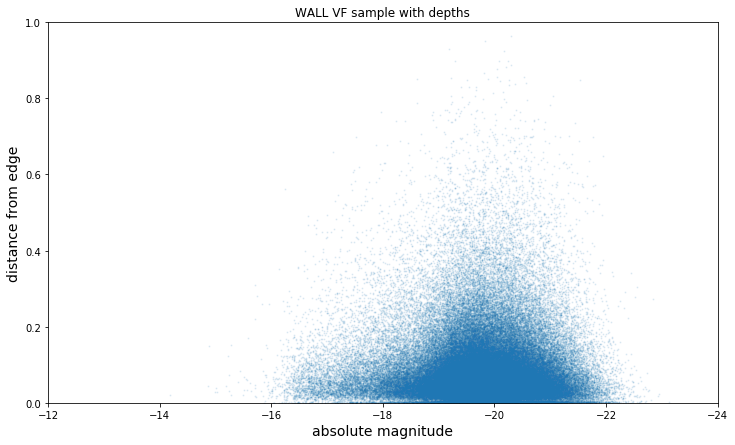

In [114]:
plt.figure(figsize=(12,7))

plt.scatter(data['rabsmag'][ind_vf_wall],new_depths['DEPTH_NORM'][data['flag_voidfinder'] == 0],alpha=0.1, s=1) # void vf
plt.ylim(0,1)
plt.xlim(-12,-24)
plt.xlabel("absolute magnitude", fontsize=14)
plt.title("WALL VF sample with depths")
plt.ylabel("distance from edge", fontsize=14)
plt.show()# the deeper objects are brighter

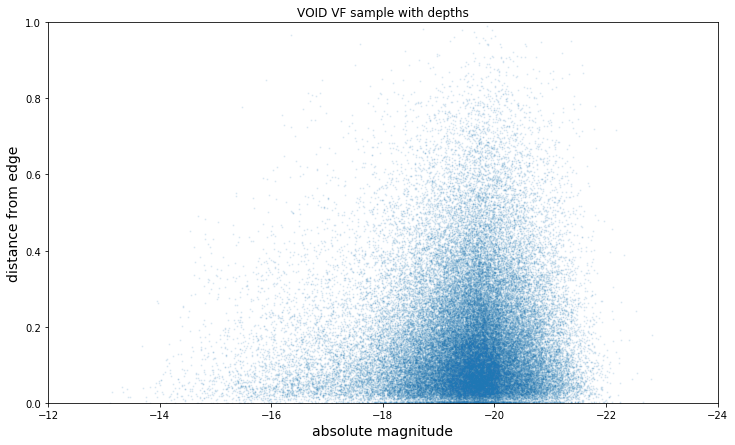

In [10]:
plt.figure(figsize=(12,7))
plt.scatter(data['rabsmag'][ind_vf_void],new_depths['DEPTH_NORM'][data['flag_voidfinder'] == 1],alpha=0.1, s=1) # void vf
plt.ylim(0,1)
plt.xlim(-12,-24)
plt.xlabel("absolute magnitude", fontsize=14)
plt.title("VOID VF sample with depths")
plt.ylabel("distance from edge", fontsize=14)
plt.show()# the deeper objects are brighter

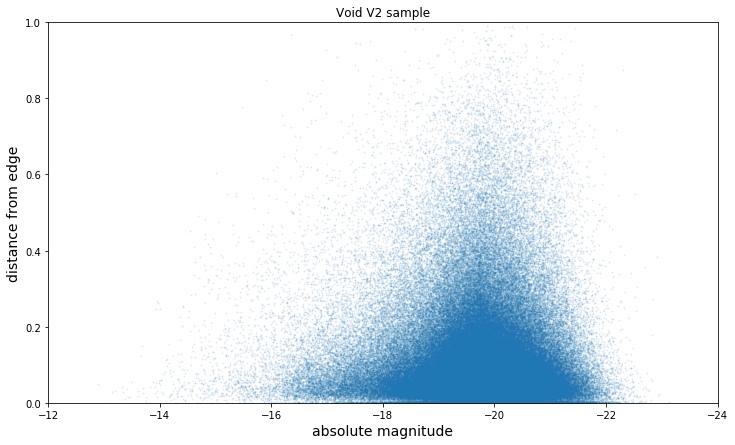

In [117]:
plt.figure(figsize=(12,7))

plt.scatter(data['rabsmag'][ind],new_depths['DEPTH_NORM'][data['flag_vsquared'] == 1],alpha=0.1, s=1) # void vf
plt.ylim(0,1)
plt.xlim(-12,-24)
plt.xlabel("absolute magnitude", fontsize=14)
plt.title("Void V2 sample")
plt.ylabel("distance from edge", fontsize=14)
plt.show()# the deeper objects are brighter # voidfinder depths # slides

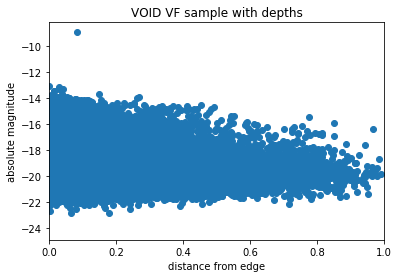

In [88]:

plt.scatter(new_depths['DEPTH_NORM'][data['flag_voidfinder'] == 1],data['rabsmag'][ind]) # void vf
plt.xlim(0,1)
plt.ylabel("absolute magnitude")
plt.title("VOID VF sample with depths")
plt.xlabel("distance from edge")
plt.show()

# for i in [-13,-14,-15,-16,-17,-18,-19,-20,-21,-22]:
#     a = i#np.random.uniform(-22+(18.2-16.8),-16+(18.2-16.8))
#     b = a-(18.2-16.8)
#     print(a,b)

#     wall_vf_rand = np.logical_and(np.logical_and(all_survey['rabsmag']>b,all_survey['rabsmag']<a), all_survey['flag_voidfinder'] == 0)
#     void_vf_rand = np.logical_and(np.logical_and(all_survey['rabsmag']>b,all_survey['rabsmag']<a), all_survey['flag_voidfinder'] == 1)

#     wall_v2_rand = np.logical_and(np.logical_and(all_survey['rabsmag']>b,all_survey['rabsmag']<a), all_survey['flag_vsquared'] == 0)
#     void_v2_rand = np.logical_and(np.logical_and(all_survey['rabsmag']>b,all_survey['rabsmag']<a), all_survey['flag_vsquared'] == 1)

#     plt.figure(figsize=(15,8))

#     # plt.hist(new_depths[data['redshift']< 0.1026]['DEPTH_NORM'], bins=np.linspace(0,1, 40), density=True, label="all V^2 void galaxies", color='cyan', alpha=0.8, histtype='step')
#     # plt.hist(new_depths[data['redshift']< 0.1026]['DEPTH_NORM'][void_v2_excess], bins=np.linspace(0,1, 40), density=True, alpha = 0.5,color="orange", label="V^2 void galaxies -18.2<M_abs<-16.8", histtype='step')

#     plt.hist(new_depths[data['redshift']< 0.1026]['DEPTH_NORM'][all_survey['flag_voidfinder'] == 1],bins=np.linspace(0,1, 40), density=True, alpha = 0.5,color="green", label="void VF out of void V2 sample",histtype='step')
#     plt.hist(new_depths[data['redshift']< 0.1026]['DEPTH_NORM'][void_vf_rand],bins=np.linspace(0,1, 40), density=True, alpha = 0.5,color="red", label="void VF out of void V2 sample random",histtype='step')

#     plt.hist(new_depths[data['redshift']< 0.1026]['DEPTH_NORM'][all_survey['flag_voidfinder'] == 0],bins=np.linspace(0,1, 40), density=True, alpha = 0.5,color="blue", label="wall VF out of void V2 sample",histtype='step')

#     plt.hist(new_depths[data['redshift']< 0.1026]['DEPTH_NORM'][wall_vf_rand],bins=np.linspace(0,1, 40), density=True, alpha = 0.5,color="black", label="wall VF out of void V2 sample random",histtype='step')
#     # plt.ylim(0,100000)

#     plt.xlabel("normalized distance from edge")
#     plt.ylabel("normalized")
#     plt.legend(fontsize=14)
#     plt.xlim(-0.05,1)
#     plt.show()




In [49]:
a,b

(-17.945527179930302, -19.3455271799303)

In [27]:
np.array(np.histogram(new_depths[data['redshift']< 0.1026]['DEPTH_NORM'][all_survey['flag_voidfinder'] == 1],bins=np.linspace(0,1, 40))[0])





array([5591, 7944, 7374, 6579, 5670, 4875, 4154, 3466, 2975, 2615, 2256,
       1842, 1677, 1428, 1272, 1081,  868,  774,  657,  601,  521,  449,
        370,  316,  286,  235,  222,  161,  149,  124,  103,   76,   44,
         38,   27,   22,   11,   10,    4])

In [8]:
a,b

(-20.207460695207732, -21.60746069520773)

In [134]:
np.linspace(0,1, 40)

array([0.        , 0.02564103, 0.05128205, 0.07692308, 0.1025641 ,
       0.12820513, 0.15384615, 0.17948718, 0.20512821, 0.23076923,
       0.25641026, 0.28205128, 0.30769231, 0.33333333, 0.35897436,
       0.38461538, 0.41025641, 0.43589744, 0.46153846, 0.48717949,
       0.51282051, 0.53846154, 0.56410256, 0.58974359, 0.61538462,
       0.64102564, 0.66666667, 0.69230769, 0.71794872, 0.74358974,
       0.76923077, 0.79487179, 0.82051282, 0.84615385, 0.87179487,
       0.8974359 , 0.92307692, 0.94871795, 0.97435897, 1.        ])

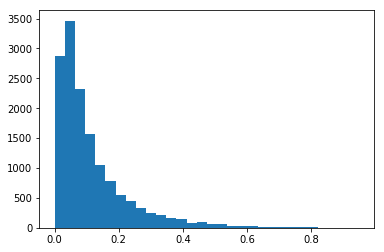

In [128]:
plt.hist(new_depths[data['redshift']< 0.1026]['DEPTH_NORM'][void_v2_excess], bins=30)
plt.show()

In [202]:
# plt.hist(new_depths['DEPTH_NORM'],bins=np.linspace(0,1,100), density=True, label="all")

# plt.hist(new_depths['DEPTH_NORM'][np.intersect1d(wall_v2,bump_mstar_index)],bins=np.linspace(0,1,100), density=True, alpha=0.3)
# plt.legend()

# plt.show()

In [203]:
# len(np.intersect1d(void_v2,bump_mstar_index))

NameError: name 'wall_v2' is not defined

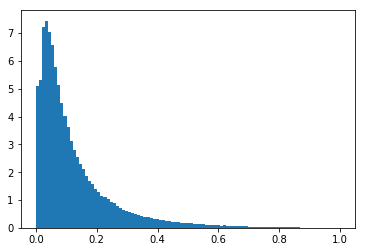

In [4]:
plt.hist(new_depths['DEPTH_NORM'],bins=np.linspace(0,1,100), density=True, label="all")

plt.hist(new_depths['DEPTH_NORM'][np.intersect1d(wall_v2,bump_mstar_index)],bins=np.linspace(0,1,100), density=True, alpha=0.3)
plt.legend()

plt.show()

In [205]:

# gal_sorted = gal_depth[np.flip(np.argsort(norm_depth))] # galaxies sorted by largest depth to smallest
# # norm_depth[np.argwhere(gal_depth == X)]  # to find norm_depth associated with galaxy X
# #check that the galaxies are sorted in ascending order of the normalized depths
# gal_sorted[500] == gal_depth[np.argwhere(norm_depth==np.flip(np.sort(norm_depth))[500])]


# num_slices = 50
# last_slice_count =len(gal_sorted[:(np.int(len(gal_sorted)/num_slices))*num_slices])

# ind_gal_depth_voidv2_new = []
# temp=[]
# # for i in binning_log_e:
# #     temp.append(new_depths['GAL_ID'][(new_depths['DEPTH_NORM'] != -1) &(new_depths['DEPTH_NORM']>i)])
# #     ind_gal_depth_voidv2_new.append(temp)
# #     temp=[]

# for i in range(num_slices):
#     temp.append(gal_sorted[:(np.int(len(gal_sorted)/num_slices))*(i+1)])
#     ind_gal_depth_voidv2_new.append(temp)
#     temp=[]  
# for i in range(len(gal_sorted)-last_slice_count):
#     ind_gal_depth_voidv2_new[-1][0] = np.append(gal_sorted[last_slice_count:len(gal_sorted)][i],ind_gal_depth_voidv2_new[-1][0])
    
# ind_gal_depth_voidv2_new = np.array(ind_gal_depth_voidv2_new).reshape((num_slices,))

# #check
# len(ind_gal_depth_voidv2_new[-1]) == len(gal_sorted)

# # np.save('ind_gal_depth_voidv2_50_log_e', ind_gal_depth_voidv2_new)
# np.save('ind_gal_depth_voidv2_equal_slices', ind_gal_depth_voidv2_new)

# # sorted_gal_in=[]
# # for i in range(len(norm_depth)):
# #     sorted_gal_in.append(np.argwhere(norm_depth == np.flip(np.sort(norm_depth))[i]))
# # sorted_gal=[]
# # for i in range(len(gal_depth)):
# #     sorted_gal.append(gal_depth[np.array(sorted_gal_in)[i].flatten().astype('int')])
# # sorted_gal_int=[]
# # for i in range(len(sorted_gal)):
# #     for k in range(len(sorted_gal[i])):
# #         sorted_gal_int.append(sorted_gal[i][k])  
# # sorted_gal_int= np.array(sorted_gal_int)

# # binning = np.abs(np.log(np.linspace(1,0.01,80)))
# # binning = binning[binning<1]
# # binning_log_e= np.append(binning,1)
# # binning_log_e = np.flip(binning_log_e)[1:]
# # binning_log_e

# # ind_gal_depth_voidv2_new = []
# # temp=[]
# # for i in binning_log_e:
# #     temp.append(new_depths['GAL_ID'][(new_depths['DEPTH_NORM'] != -1) &(new_depths['DEPTH_NORM']>i)])
# #     ind_gal_depth_voidv2_new.append(temp)
# #     temp=[]


In [206]:
# void_depth = new_depths[void_v2]['DEPTH_NORM']
# void_depth_ind = new_depths[np.argwhere(new_depths['DEPTH_NORM']==new_depths[void_v2]['DEPTH_NORM'])]

In [207]:
# void_depth_ind=[]
# for i in range(len(void_depth)):
#     void_depth_ind.append()

In [208]:
# void_depth_bump=np.intersect1d(bump_mstar_index,void_depth_ind)

In [209]:
# fig = plt.figure(figsize=(15,10))
# plt.hist(new_depths[void_bump]['DEPTH_NORM'], np.linspace(-2,1,300), label="bump")
# plt.hist(random.sample(new_depths[np.argwhere(new_depths[void_v2]['DEPTH_NORM']!= -1)]['DEPTH_NORM'],len(void_bump)), np.linspace(-2,1,300), alpha=0.5, label="random")
# plt.legend()
# plt.show()

### Importing data and classification

In [46]:
# data_old = Table.read('data_flags_updated_Oct8.dat', format = 'ascii')
data = Table.read('data_flags_updated_Nov1.dat', format = 'ascii')

In [3]:
# list_ = []
# for i in np.linspace(0.1,2,100):
#     with open('galaxy_in_voidv2_indices'+str(i), 'rb') as ind_file:
#         list_.append(pickle.load(ind_file))
# list_= np.array(list_)
# len(list_)

# #flatten the index file, np.flatten doesnt get it done
# ind_maximal_voidgal=[] # 18 arrays, each contains the list of galaxies within that radius of the maximal sphere
# temp=[]
# for k in range(len(list_)):
#     for i in range(len(list_[k])): #641
#         for j in range(len(list_[k][i])): # number of particles in maximal sphere
#             temp.append(list_[k][i][j]) 
#     ind_maximal_voidgal.append(temp)
#     temp=[]
# ind_maximal_voidgal=np.array(ind_maximal_voidgal)

# np.array(ind_maximal_voidgal).shape

In [47]:
# ra,dec,z
ra = np.array(data['ra'])
dec = np.array(data['dec'])
z = np.array(data['redshift'])

#stellar mass
Mstar = np.array(data['Mstar'])
# Mstar = Mstar[np.logical_not(np.isnan(Mstar))] 
Mstar_NSA= np.array(data['Mstar_NSA'])
# color
u_r = np.array(data['u_r'])
# u_r = u_r[np.logical_not(np.isnan(u_r))] 

g_r = np.array(data['g_r'])
# g_r = g_r[np.logical_not(np.isnan(g_r))] 

# u_r_NSA = np.array(data['u_r_NSA'])
# g_r_NSA = np.array(data['g_r_NSA'])
# absolute magniture
rabsmag = np.array(data['rabsmag'])
# rabsmag = rabsmag[np.logical_not(np.isnan(rabsmag))] 

rabsmag_NSA = np.array(data['rabsmag_NSA'])
#star formation rate and specific SPR
SFR  = np.array(data['SFR'])
# SFR = SFR[np.logical_not(np.isnan(SFR))] 

sSFR = np.array(data['sSFR'])
# sSFR = sSFR[np.logical_not(np.isnan(sSFR))] 

#classification V^2

wall_v2 = np.argwhere(data['flag_vsquared'] == 0).flatten()
void_v2 = np.argwhere(data['flag_vsquared'] == 1).flatten()
edge_v2 = np.argwhere(data['flag_vsquared'] == 2).flatten()
out_v2 = np.argwhere(data['flag_vsquared'] == 9).flatten()

#classification voidfinder

wall_vf = np.argwhere(data['flag_voidfinder'] == 0).flatten()
void_vf = np.argwhere(data['flag_voidfinder'] == 1).flatten()
edge_vf = np.argwhere(data['flag_voidfinder'] == 2).flatten()
out_vf = np.argwhere(data['flag_voidfinder'] == 9).flatten()

# len(wall_v2)+len(void_v2)+len(edge_v2)+len(out_v2),len(wall_vf)+len(void_vf)+len(edge_vf)+len(out_vf), len(data) #check

In [43]:
all_survey = data[data['redshift']< 0.1026]

In [212]:
np.max(all_survey['dec'])-np.min(all_survey['dec'])

81.505031

In [59]:
wall_vf_survey = np.argwhere(all_survey['flag_voidfinder'] == 0).flatten()
void_vf_survey = np.argwhere(all_survey['flag_voidfinder'] == 1).flatten()
edge_vf_survey = np.argwhere(all_survey['flag_voidfinder'] == 2).flatten()
out_vf_survey = np.argwhere(all_survey['flag_voidfinder'] == 9).flatten()

wall_v2_survey = np.argwhere(all_survey['flag_vsquared'] == 0).flatten()
void_v2_survey = np.argwhere(all_survey['flag_vsquared'] == 1).flatten()
edge_v2_survey = np.argwhere(all_survey['flag_vsquared'] == 2).flatten()
out_v2_survey = np.argwhere(all_survey['flag_vsquared'] == 9).flatten()

In [ ]:
# all_survey = data[data['redshift']< 0.1026]
# glx_M_ind = np.logical_and(all_survey['rabsmag']>-18.2, all_survey['rabsmag']<-16.8)

# wall_vf_M_ind = all_survey[glx_M_ind]['flag_voidfinder'] ==0
# void_vf_M_ind = all_survey[glx_M_ind]['flag_voidfinder'] ==1

# void_v2_M_ind = all_survey[glx_M_ind]['flag_vsquared'] ==1
# wall_v2_M_ind = all_survey[glx_M_ind]['flag_vsquared'] ==0



In [190]:
glx_M_ind = np.logical_and(all_survey['rabsmag']>-18.2, all_survey['rabsmag']<-16.8) # index from all survey of 
# galaxies with -18.2<M<-16.8 total of 29433 galaxies.
# out of these for  #np.sum(all_survey[glx_M_ind]['flag_vsquared'] ==9)
#---VF: 14035 are wall , 8506 are void, 6892 are edge , 0 outside.
#---V2: 11716 are wall , 14665 are void, 3039 are edge , 13 outside.

In [196]:
wall_v2_M_ind = all_survey[glx_M_ind]['flag_vsquared'] ==0
wall_vf_M_ind = all_survey[glx_M_ind]['flag_voidfinder'] ==0

void_v2_M_ind = all_survey[glx_M_ind]['flag_vsquared'] ==1
void_vf_M_ind = all_survey[glx_M_ind]['flag_voidfinder'] ==1

In [38]:



c = 299792




def f(a,omega_m):
     return 1/(np.sqrt(a*omega_m*(1+((1-omega_m)*a**3/omega_m))))



def Distance(z,omega_m,h):
    dist = np.ones(len(z))
    H0 = 100*h
    for i,redshift in enumerate(z):
        a_start = 1/(1+redshift)
        I = quad(f,a_start,1,args=omega_m)
        dist[i] = I[0]*(c/H0)
    return dist

# def Rabsmag(omega_m,app_mag,z,h):
#     comovingdist = Distance(z,omega_m,h)*1e6
#     return app_mag -(5*np.log10(comovingdist))+5

In [213]:
from astropy import units as u

In [220]:
d = 301*u.parsec*10**(-6)

In [225]:
d

<Quantity 0.000301 pc>

In [230]:
ra_=(360*u.deg).to(u.rad)
dec_=(81*u.deg).to(u.rad)

In [231]:
A=(ra_/2)*(301**2) #Mpc^2
A

<Quantity 284631.43600789 rad>

In [221]:
ra=s/d  # radi

UnitConversionError: 'pc' (length) and 'deg' (angle) are not convertible

In [209]:
Distance([0,0.1026],0.26,1)  #Mpc

array([  0.        , 301.27299424])

In [195]:
np.max(all_survey[glx_M_ind][wall_vf_M_ind]['redshift'])-np.min(all_survey[glx_M_ind][wall_vf_M_ind]['redshift'])

0.046657

In [194]:
np.max(all_survey[glx_M_ind][wall_v2_M_ind]['redshift'])-np.min(all_survey[glx_M_ind][wall_v2_M_ind]['redshift'])

0.050605

In [198]:
np.max(all_survey[glx_M_ind][void_v2_M_ind]['redshift'])-np.min(all_survey[glx_M_ind][void_v2_M_ind]['redshift'])

0.048368

In [199]:
np.max(all_survey[glx_M_ind][wall_v2_M_ind]['redshift'])-np.min(all_survey[glx_M_ind][wall_v2_M_ind]['redshift'])

0.050605

In [183]:
all_survey[glx_M_ind][wall_vf_M_ind]['redshift']

<Column name='redshift' dtype='float64' length=0>

In [182]:
np.max(all_survey[glx_M_ind][wall_vf_M_ind]['redshift'])-np.min(all_survey[glx_M_ind][wall_vf_M_ind]['redshift'])

ValueError: zero-size array to reduction operation maximum which has no identity

In [171]:
len(wall_v2_M_ind), len(glx_M_ind)

(29433, 366727)

In [160]:
z_gap=[]
ra_gap=[]
dec_gap=[]
z_max=[]
z_min=[]
for i in range(500):
    a = np.random.uniform(-22+(18.2-16.8),-16+(18.2-16.8))
    b = a-(18.2-16.8)
#     a,b
    glx_M_ind_test = np.logical_and(all_survey['rabsmag']>b, all_survey['rabsmag']<a) # index from all survey of 
    z_gap.append((np.max(all_survey[glx_M_ind_test]['redshift'])-np.min(all_survey[glx_M_ind_test]['redshift'])))
    ra_gap.append((np.max(all_survey[glx_M_ind_test]['ra'])-np.min(all_survey[glx_M_ind_test]['ra'])))
    dec_gap.append((np.max(all_survey[glx_M_ind_test]['dec'])-np.min(all_survey[glx_M_ind_test]['dec'])))
    z_max.append(np.max(all_survey[glx_M_ind_test]['redshift']))
    z_min.append(np.min(all_survey[glx_M_ind_test]['redshift']))

    # total redshift gap: 0.1026, dec_gap=81.505031, ra_gap=359.988597
#     z_gap,ra_gap,dec_gap

In [237]:
0.095261, 0.099704,0.080,0.04

[-20.6, -19.200000000000003, -17.800000000000004, -16.400000000000006]

In [249]:
glx_M_ind_test = np.logical_and(all_survey['rabsmag']>-22+4*(18.2-16.8), all_survey['rabsmag']<-22+5*(18.2-16.8)) # index from all survey of 
z_gap=(np.max(all_survey[glx_M_ind_test]['redshift'])-np.min(all_survey[glx_M_ind_test]['redshift']))
ra_gap=(np.max(all_survey[glx_M_ind_test]['ra'])-np.min(all_survey[glx_M_ind_test]['ra']))
dec_gap=(np.max(all_survey[glx_M_ind_test]['dec'])-np.min(all_survey[glx_M_ind_test]['dec']))
z_max=np.max(all_survey[glx_M_ind_test]['redshift'])
z_min=np.min(all_survey[glx_M_ind_test]['redshift'])

In [250]:
z_gap

0.02461

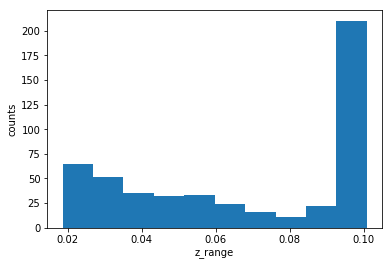

In [232]:
plt.hist(z_gap) # similar to z_max
plt.xlabel("z_range")
plt.ylabel("counts")
plt.show()

(0.07550100000000001, 359.95642699999996, 81.348173)

In [105]:
np.max(all_survey[glx_M_ind]['redshift'])

0.052938

In [100]:
(np.max(all_survey[glx_M_ind]['redshift'])-np.min(all_survey[glx_M_ind]['redshift']))

0.051803999999999996

In [102]:
(np.max(all_survey[glx_M_ind]['ra'])-np.min(all_survey[glx_M_ind]['ra'])), np.max(all_survey['ra'])-np.min(all_survey['ra'])

(359.88966500000004, 359.98859799999997)

In [103]:
(np.max(all_survey[glx_M_ind]['dec'])-np.min(all_survey[glx_M_ind]['dec'])), np.max(all_survey['dec'])-np.min(all_survey['dec'])

(81.333935, 81.505031)

In [55]:
np.sum(glx_M_ind)

29433

In [10]:
len(void_vf)/len(wall_vf), len(wall_v2)/len(void_v2)

(0.501055631519114, 0.5258210572719592)

In [22]:
print("why would the galaxies with -18<M<-16 be more likely to fall in the walls of v^2. if they subtend a small volume of the survey ")

why would the galaxies with -18<M<-16 be more likely to fall in the walls of v^2. if they subtend a small volume of the survey 


In [19]:
len(wall_v2), len(void_v2)

(114507, 217768)

In [33]:
np.intersect1d??

In [35]:
len(np.unique(wall_v2)), len(wall_v2)

(114507, 114507)

In [30]:
inter_wall = np.intersect1d(wall_vf, wall_v2, return_indices=True)

In [40]:
len(wall_v2), len(wall_vf), len(inter_wall[0])

(114507, 190881, 58814)

In [36]:
wall_vf[np.array(inter_wall)[1]]

array([   466,    471,    594, ..., 707812, 707813, 707816])

In [37]:
wall_v2[np.array(inter_wall)[2]]

array([   466,    471,    594, ..., 707812, 707813, 707816])

In [14]:
len(np.intersect1d(void_vf, void_v2)), len(void_vf), len(void_v2)

(66867, 95642, 217768)

In [17]:
len(np.intersect1d(void_v2, wall_vf)), len(void_v2), len(wall_vf)

(131980, 217768, 190881)

### void environment of galaxies with apparents magnitude <-20 and >-20

In [24]:
bright_ind=np.argwhere(data['rabsmag'] <-20).flatten()

In [28]:
bright_wall_v2=np.intersect1d(wall_v2,bright_ind)
bright_out_v2=np.intersect1d(out_v2,bright_ind)
bright_void_v2=np.intersect1d(void_v2,bright_ind)
bright_edge_v2=np.intersect1d(edge_v2,bright_ind)

bright_wall_vf=np.intersect1d(wall_vf,bright_ind)
bright_out_vf=np.intersect1d(out_vf,bright_ind)
bright_void_vf=np.intersect1d(void_vf,bright_ind)
bright_edge_vf=np.intersect1d(edge_vf,bright_ind)

In [29]:
faint_ind=np.argwhere(data['rabsmag'] >-20).flatten()

In [30]:
faint_wall_v2=np.intersect1d(wall_v2,faint_ind)
faint_out_v2=np.intersect1d(out_v2,faint_ind)
faint_void_v2=np.intersect1d(void_v2,faint_ind)
faint_edge_v2=np.intersect1d(edge_v2,faint_ind)

faint_wall_vf=np.intersect1d(wall_vf,faint_ind)
faint_out_vf=np.intersect1d(out_vf,faint_ind)
faint_void_vf=np.intersect1d(void_vf,faint_ind)
faint_edge_vf=np.intersect1d(edge_vf,faint_ind)

In [188]:
def hist_bright(voidfinder=True):
    if voidfinder:
        wall=bright_wall_vf
        void=bright_void_vf
        edge=bright_edge_vf
        out=bright_out_vf
        label="bright VF"
    if voidfinder ==False:
        wall=bright_wall_v2
        void=bright_void_v2
        edge=bright_edge_v2
        out=bright_out_v2     
        label="bright V2"
    plt.figure(figsize=(35, 20))
    plt.hist(rabsmag[edge], label="edge",bins=np.linspace(-21,-5, 350), color="purple", alpha=0.4)
    plt.hist(rabsmag[wall], alpha =0.5, color="green",label="wall",bins=np.linspace(-23,-19.9, 250))
    plt.hist(rabsmag[bright_ind], alpha =0.1,color='gray', label="all faint",bins=np.linspace(-23,-19.9, 250))

#     plt.hist(rabsmag[out], alpha=0.4, color="blue",label="out",bins=np.linspace(-23,-19.9, 250))
    plt.hist(rabsmag[void], alpha =0.4,color="red", label="void",bins=np.linspace(-23,-19.9, 250))
    plt.title(label, fontsize=35)
    plt.legend(fontsize=35)
    plt.xlim(-19.8,-23.1)
    plt.xlabel("abs_mag", fontsize=35)
    plt.show()

In [194]:
def hist_faint(voidfinder=True):
    if voidfinder:
        wall=faint_wall_vf
        void=faint_void_vf
        edge=faint_edge_vf
        out=faint_out_vf
        label="faint VF"
    if voidfinder ==False:
        wall=faint_wall_v2
        void=faint_void_v2
        edge=faint_edge_v2
        out=faint_out_v2     
        label="faint V2"
    plt.figure(figsize=(35, 20))
    plt.hist(rabsmag[edge], label="edge",bins=np.linspace(-21,-5, 350), color="purple", alpha=0.4)
    plt.hist(rabsmag[wall], alpha =0.5, color="green",label="wall",bins=np.linspace(-21,-5, 200))
    plt.hist(rabsmag[faint_ind], alpha =0.2,color='gray', label="all faint",bins=np.linspace(-21,-5, 200))

#     plt.hist(rabsmag[out], alpha=0.4, color="blue",label="out",bins=np.linspace(-21,-5, 200))
    plt.hist(rabsmag[void], alpha =0.4,color="red", label="void",bins=np.linspace(-21,-5, 200))
    plt.title(label, fontsize=35)
    plt.legend(fontsize=35)
    plt.xlim(-5,-21)
    plt.xlabel("abs_mag", fontsize=35)

    plt.show()

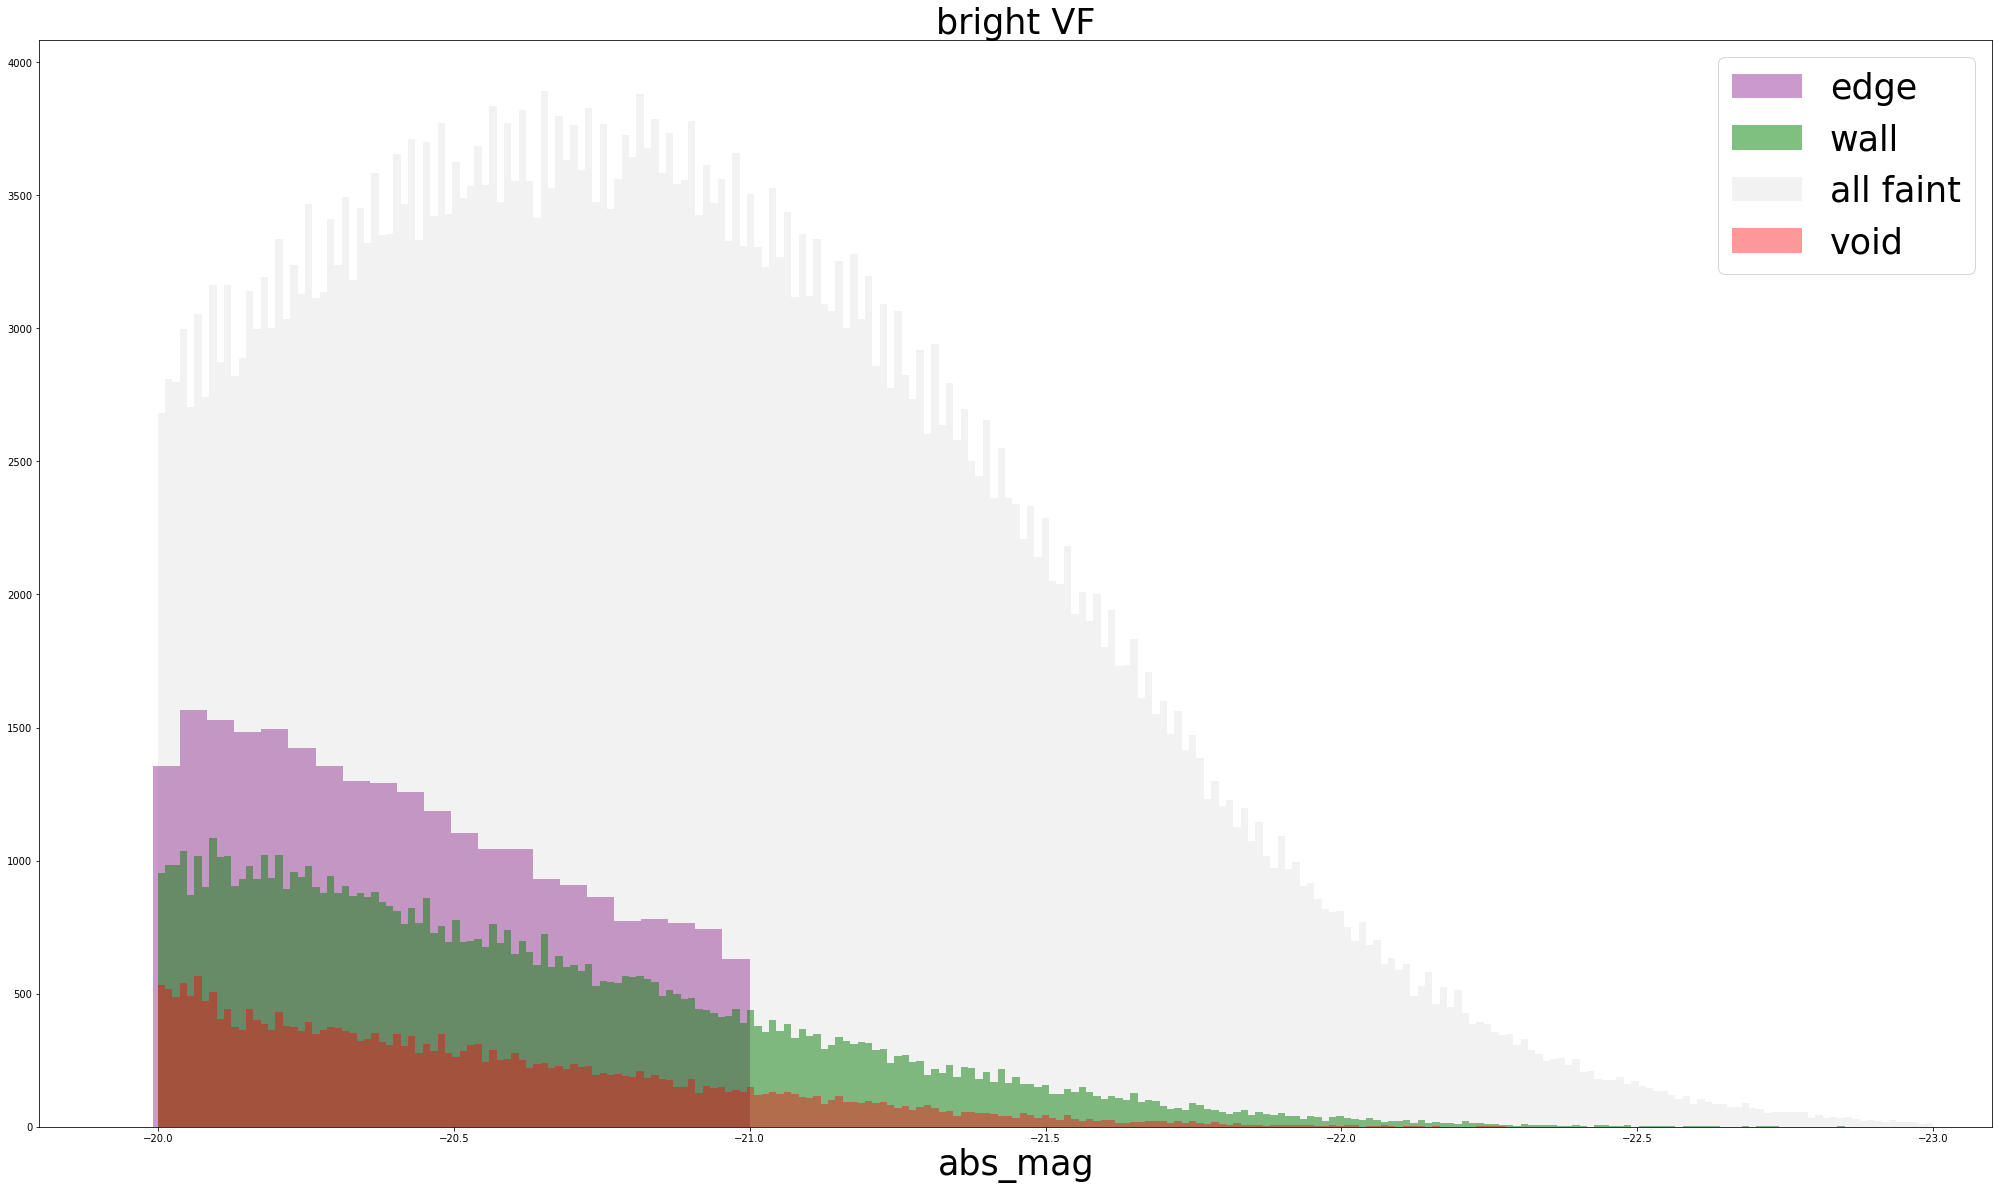

In [195]:
hist_bright()

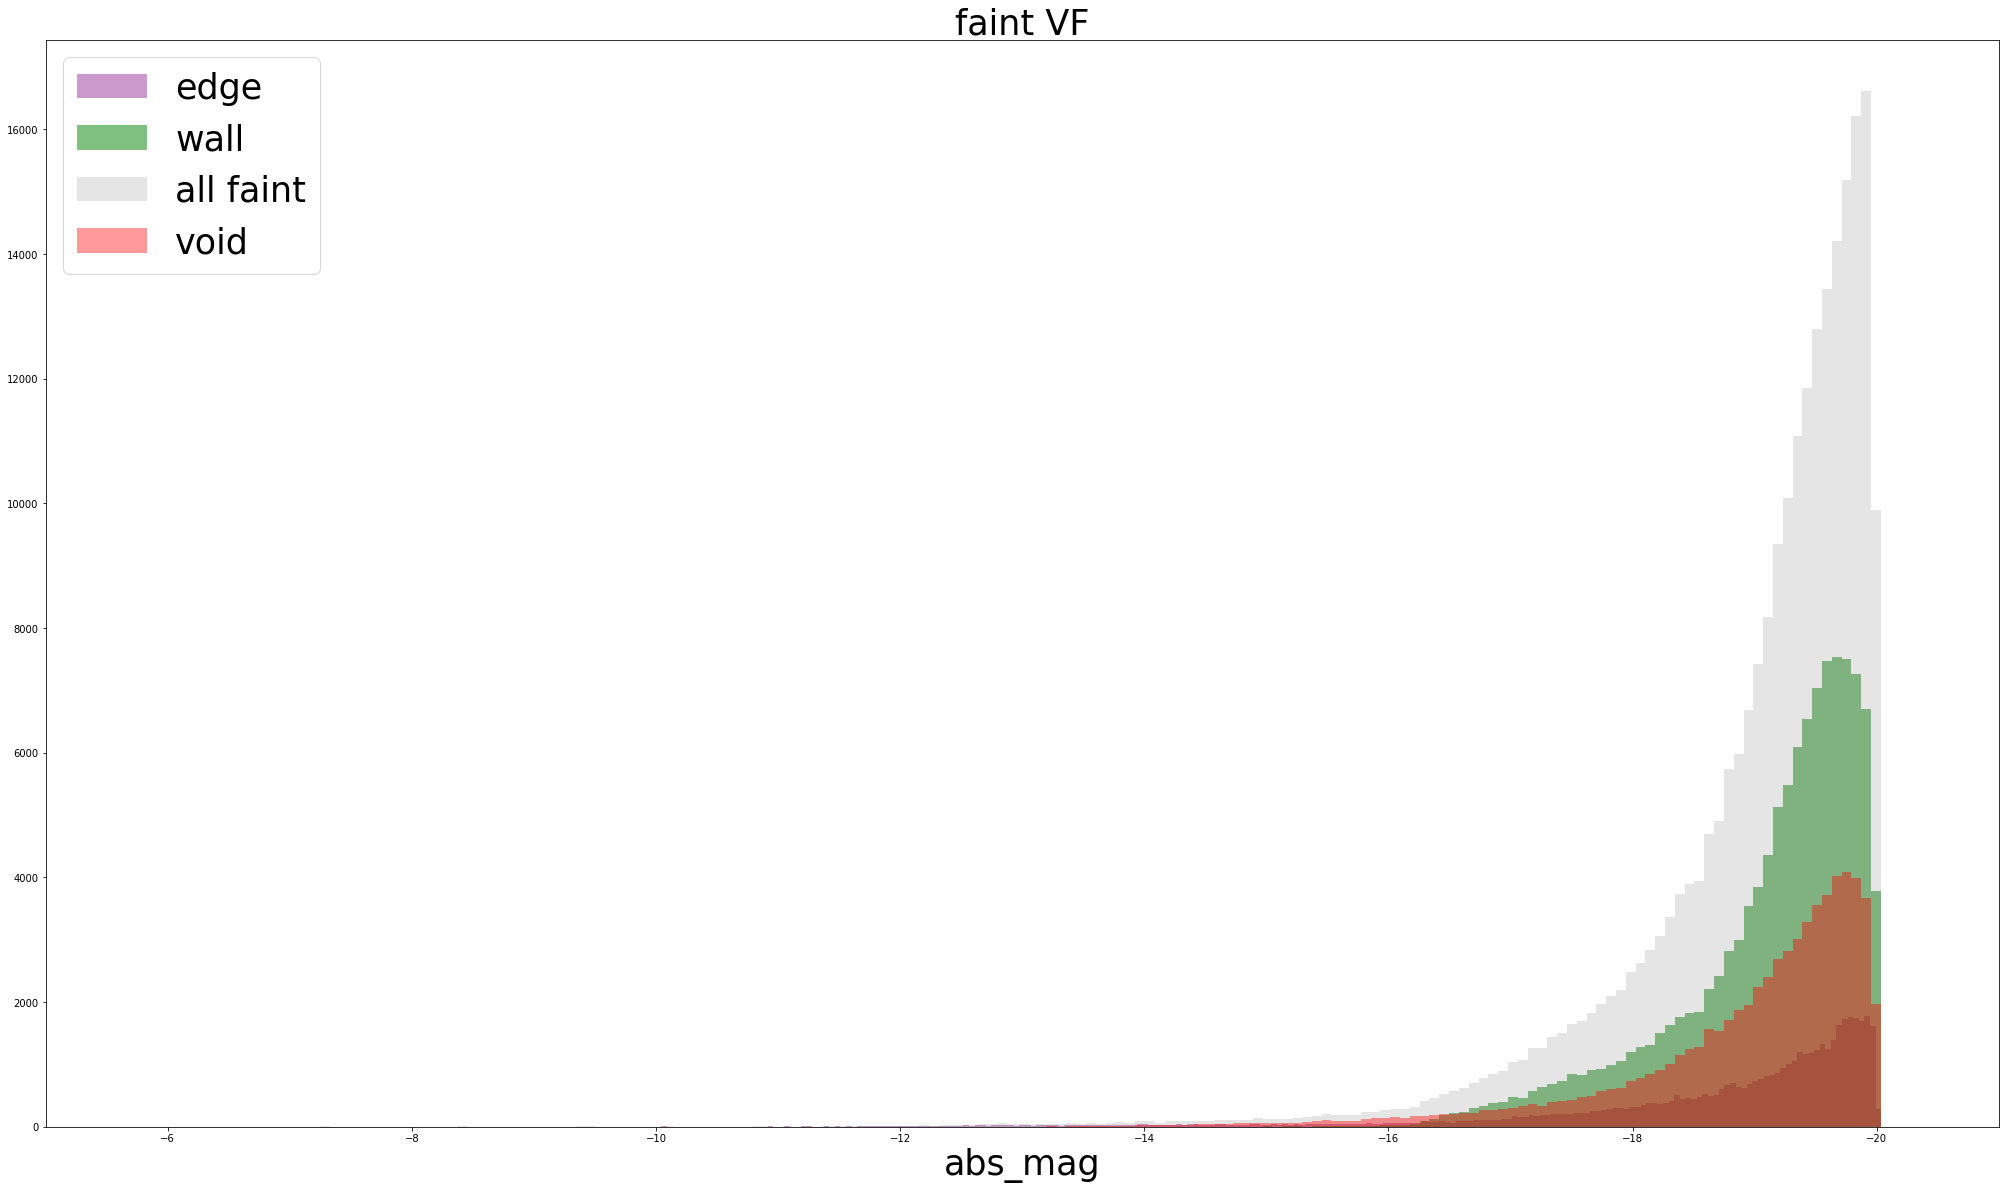

In [196]:
hist_faint()

In [201]:
len(void_vf)

95642

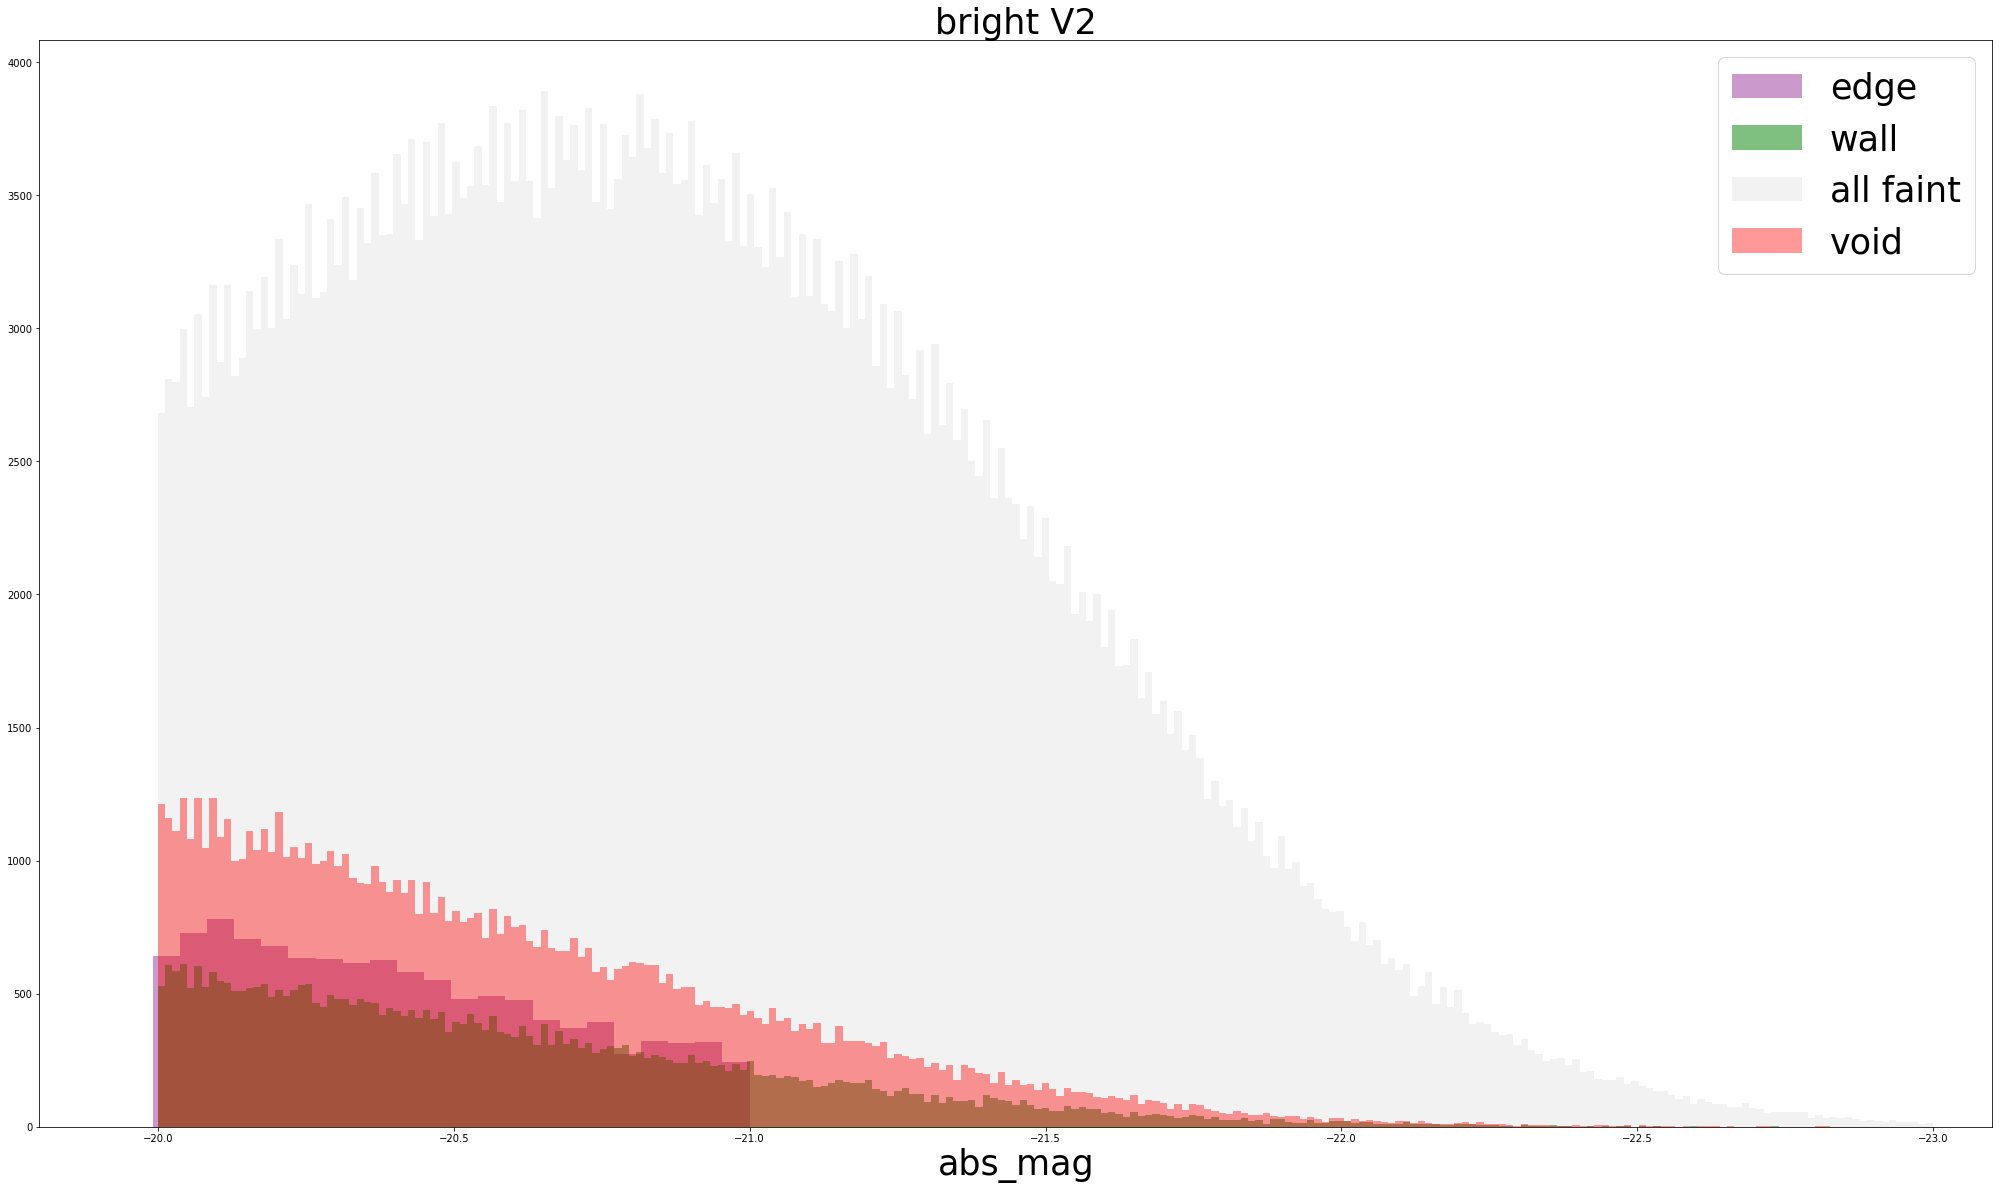

In [197]:
hist_bright(voidfinder=False)

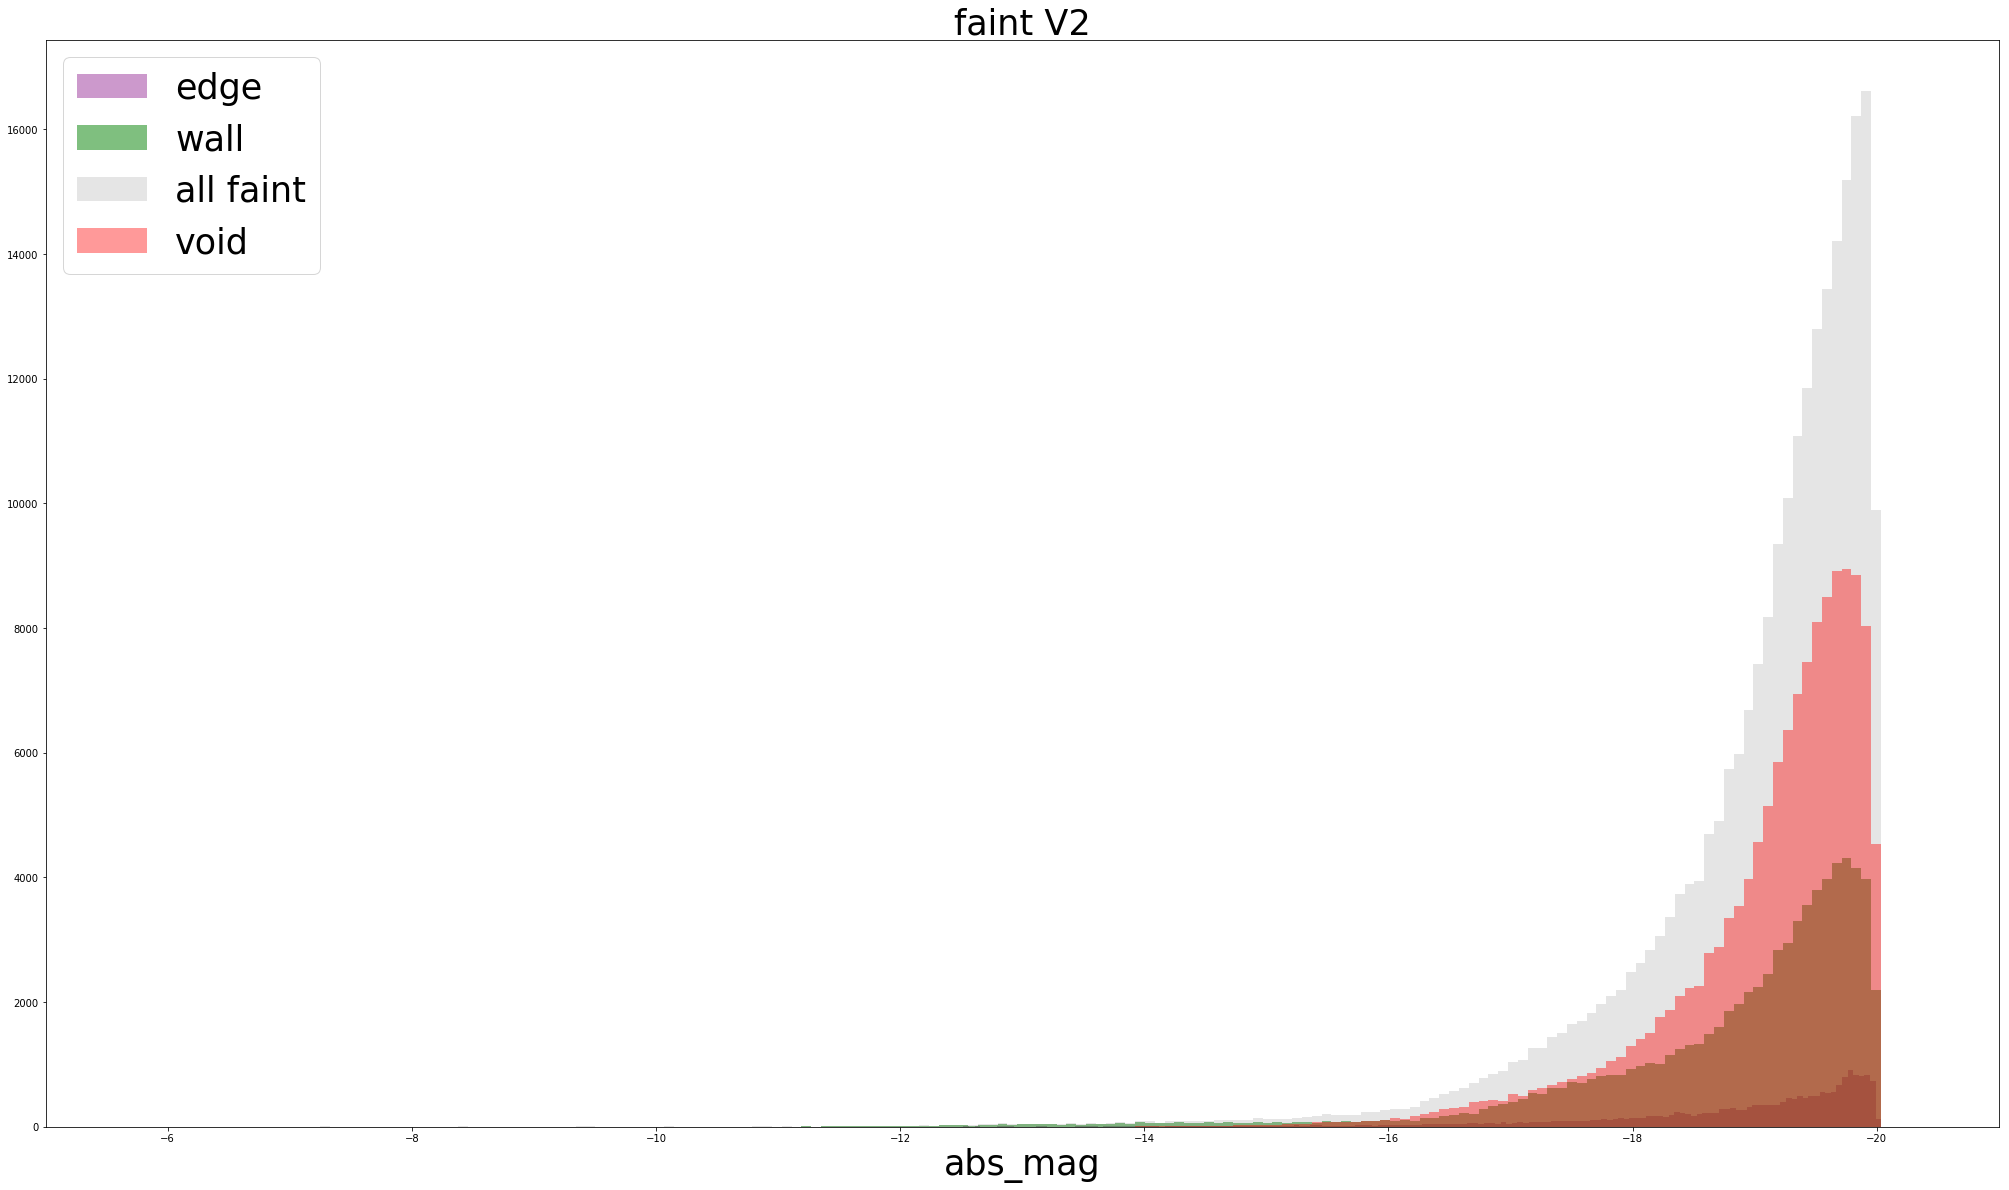

In [198]:
hist_faint(voidfinder=False)

test

In [16]:
# wall_v2_old = np.argwhere(data_old['flag_vsquared'] == 0).flatten()
# void_v2_old = np.argwhere(data_old['flag_vsquared'] == 1).flatten()
# edge_v2_old = np.argwhere(data_old['flag_vsquared'] == 2).flatten()
# out_v2_old = np.argwhere(data_old['flag_vsquared'] == 9).flatten()

# #classification voidfinder

# wall_vf_old = np.argwhere(data_old['flag_voidfinder'] == 0).flatten()
# void_vf_old = np.argwhere(data_old['flag_voidfinder'] == 1).flatten()
# edge_vf_old = np.argwhere(data_old['flag_voidfinder'] == 2).flatten()
# out_vf_old = np.argwhere(data_old['flag_voidfinder'] == 9).flatten()

In [8]:
print(len(wall_v2),len(void_v2) ,len(edge_v2),len(out_v2))
print(len(wall_vf),len(void_vf) , len(edge_vf), len(out_vf))


114507 217768 34392 341150
190881 95642 78696 342598


In [12]:
# ind_gal_maximal_voidv2 = []

# for i in range(len(ind_maximal_voidgal)):
#     ind_gal_maximal_voidv2.append(list(set(ind_maximal_voidgal[i]) & set(void_v2)))

# ind_gal_maximal_voidv2= np.array(ind_gal_maximal_voidv2)
# ind_gal_maximal_voidv2.shape

In [13]:
# galzone = Table.read('DR7_galzones.dat', format =  'ascii' )
# depth = np.array(galzone['depth'])
# galaxy_depth = []
# for i in range(np.max(depth)):
#     galaxy_depth.append(np.argwhere(depth==i))
# galaxy_depth=np.array(galaxy_depth)

In [14]:
# ind_gal_depth_voidv2 = []

# for j in range(galaxy_depth.shape[0]):
#     print(j)
#     ind_gal_depth_voidv2.append(galaxy_depth[j][np.isin(galaxy_depth[j],void_v2)])
# ind_gal_depth_voidv2= np.array(ind_gal_depth_voidv2)
# ind_gal_depth_voidv2.shape

### Where does the galaxies that are assigned a depth lie?

In [15]:
# plt.hist(z[void_v2])
# plt.show()
# plt.hist(z[gal_depth])
# plt.show()

In [16]:
# plt.figure(figsize=(45, 25))
# plt.scatter(ra[gal_depth][0.1<z<0.2], dec[gal_depth][0.1<z<0.2], color='orange', alpha=0.5, label="depth")
# # plt.scatter(ra,dec, alpha=0.01)
# # plt.scatter(ra[void_v2],dec[void_v2], alpha=0.05, label="void")
# # plt.title("dec/ra overlap of void galaxies and galaxies with depth", fontsize=45)
# # plt.legend(fontsize=45)
# # plt.xlabel("ra",fontsize=45)
# # plt.ylabel("dec",fontsize=45)
# # plt.savefig("overlap_void_depth.eps", dpi=150)
# # plt.show()

### plotting as a function of depth

In [9]:
def char_inside(char_, bins_,i, title='galaxy property', label='x-label', voidfinder=False,x=None,y=None):
    '''
    Plots a histogram for a galaxy charachterstic for wall and void galaxies for void depth analysis
    
    arguments:
    
    char_ : (numpy array) charachteristic of galaxy desired for plotting
    bins_ : (numpy linear space) histogram bins
    voidfinder : (bool) True if the classification comes from the voidfinder algorithm, False if it comes from V^2
    x: x coordinate of the location of the algorithm's name 
    y: y coordinate of the location of the algorithm's name
    '''    
#     void_vf = ind_maximal_voidgal[i]
    void_v2=ind_gal_depth_voidv2_new[i]
#     for j in range(i+1):
#         void_v2= np.append(void_v2,ind_gal_depth_voidv2_new[j])
#     void_v2.astype(int)

#     void_v2=np.array(new_depths['GAL_ID'][(new_depths['DEPTH_NORM'] != -1)])#ind_gal_depth_voidv2_new[i]
    if voidfinder == True:
        char_wall = char_[wall_vf]
        char_void = char_[void_vf]
#         char_edge = char_[edge_vf]
#         char_out = char_[out_vf]
        x_vf=x
        y_vf=y
    else:
        char_wall = char_[wall_v2]
        char_void = char_[void_v2]
#         char_edge = char_[edge_v2]
#         char_out = char_[out_v2]
        x_v2=x
        y_v2=y
    fig, ax = plt.subplots(figsize=(10, 6))
    
    counts_wall, bins_wall = np.histogram(char_wall, bins= bins_)
    counts_void, bins_void = np.histogram(char_void, bins= bins_)
    
#     counts_edge, bins_edge = np.histogram(char_edge, bins= bins_)
#     counts_out, bins_out = np.histogram(char_out, bins= bins_)
    
    counts_all, bins_all = np.histogram(char_[data['redshift']< 0.1026], bins= bins_)
    
    
    counts_wall,counts_void = np.array(counts_wall)/len(char_wall), np.array(counts_void)/len(char_void)
#     counts_edge, counts_out = np.array(counts_edge)/len(char_edge), np.array(counts_out)/len(char_out)
    counts_all = np.array(counts_all)/len(char_[data['redshift']< 0.1026])
    
    ax.hist(bins_wall[:-1], bins=bins_wall, weights=counts_wall, label = 'Wall' , color='black', histtype='step')
    ax.hist(bins_void[:-1], bins=bins_void, weights=counts_void ,label = 'Void', color = 'red',histtype='step')
    
#     ax.hist(bins_edge[:-1], bins=bins_edge, weights=counts_edge ,label = 'Edge', color = 'green',histtype='step')
#     ax.hist(bins_out[:-1], bins=bins_out, weights=counts_out ,label = 'Out', color = 'purple',histtype='step')

    ax.hist(bins_all[:-1], bins=bins_all, weights=counts_all,  label = 'All', color = 'gray',alpha = 0.3)
    
#     if (voidfinder == True) & (x!= None):
#         ax.text(x_vf, y_vf, "VoidFinder", fontsize=20)
#     if (voidfinder == False) & (x!= None):
#         ax.text(x_v2, y_v2, r'\boldmath$V^{2}$', fontsize=20)
        
    
    ax.legend(fontsize=14)
#     plt.title(title, fontsize=18)
    ax.set_xlabel(label, fontsize=20)
    ax.set_ylabel(r"Fraction of galaxies",fontsize=20)
    
    if label == 'Absolute Magnitude' or label == 'Absolute Magnitude - NSA':
        ax.set_xlim(-12, -24) 
    
    plt.savefig("Figures_V2_radius_new/g-r/"+"g-r_depth"+"{:04d}".format(i)+".png")
    plt.show()
    
    


In [4]:
# for i in range(len(ind_gal_depth_voidv2_new)):
# #     char_inside(g_r,np.linspace(-0.5,1.5, 250),i,'Color g_r - V^2',r'\boldmath$g-r$',x=-0.35,y=0.025)
#     char_inside(Mstar,np.linspace(5.5,12.5, 250),i,r'\textbf{Star Mass - }\boldmath${V^{2}}$',r'\boldmath$M_{star} [ log(M_{sun}) ]$',x=6,y=0.8*0.019)
# # char_inside(SFR,np.linspace(-3,2, 250),len(ind_gal_depth_voidv2_new)
# # ,'star formation rate ','SFR [log(Msun/yr)]',x=-2.7,y=0.0105)

In [5]:
# for i in range(len(ind_gal_depth_voidv2_new)):
# #     char_inside(g_r,np.linspace(-0.5,1.5, 250),i,'Color g_r - V^2',r'\boldmath$g-r$',x=-0.35,y=0.025)
#     char_inside(SFR,np.linspace(-3,2, 250),i,'star formation rate ','SFR [log(Msun/yr)]',x=-2.7,y=0.0105)
# # char_inside(SFR,np.linspace(-3,2, 250),len(ind_gal_depth_voidv2_new)
# # ,'star formation rate ','SFR [log(Msun/yr)]',x=-2.7,y=0.0105)

In [6]:
# for i in range(len(ind_gal_depth_voidv2_new)):
#     char_inside(g_r,np.linspace(-0.5,1.5, 250),i,'Color g_r - V^2',r'\boldmath$g-r$',x=-0.35,y=0.025)
# #     char_inside(SFR,np.linspace(-3,2, 250),i,'star formation rate ','SFR [log(Msun/yr)]',x=-2.7,y=0.0105)
# # char_inside(SFR,np.linspace(-3,2, 250),len(ind_gal_depth_voidv2_new)
# # ,'star formation rate ','SFR [log(Msun/yr)]',x=-2.7,y=0.0105)

# #     char_inside(u_r,np.linspace(0,4, 250),i,'Color u_r - V^2',r'\boldmath$u-r$',x=0.2,y=0.016)
# #     char_inside(Mstar,np.linspace(5.5,12.5, 250),i,r'\textbf{Star Mass - }\boldmath${V^{2}}$',r'\boldmath$M_{star} [ log(M_{sun}) ]$',x=6,y=0.8*0.019)
# #     char_inside(Mstar,np.linspace(5.5,12.5, 250),i,r'\textbf{Star Mass - Voidfinder}',r'\boldmath$M_{star} [ log(M_{sun}) ]$',x=6,y=0.0178)
# #     char_inside(sSFR,np.linspace(-13,-8, 250),i,'specific star formation rate - V^2','sSFR [log(1/yr)] ',x=-12.7,y=0.0105)
# # char_void(Mstar,np.linspace(5.5,12.5, 250),'Star Mass - void galaxies',r'\boldmath$Mstar [log(M_{sun})]$')
# # CDF(Mstar,np.linspace(5.5,12.5, 700),'Cumulative Star Mass',r'\boldmath$Mstar [log(M_{sun})]$')

In [10]:
# print("since the last picture still shows a difference between the void galaxies and the wall galaxies, what are the extra galaxies that are causing the shift to diseappear?")

In [26]:
# for i in range(len(ind_gal_maximal_voidv2)):

#     char_inside(Mstar,np.linspace(5.5,12.5, 250),i,r'\textbf{Star Mass - }\boldmath${V^{2}}$',r'\boldmath$M_{star} [ log(M_{sun}) ]$',x=6,y=0.8*0.019)
#     char_inside(Mstar,np.linspace(5.5,12.5, 250),r'\textbf{Star Mass - Voidfinder}',r'\boldmath$M_{star} [ log(M_{sun}) ]$', voidfinder = True,x=6,y=0.0178)
# char_void(Mstar,np.linspace(5.5,12.5, 250),'Star Mass - void galaxies',r'\boldmath$Mstar [log(M_{sun})]$')
# CDF(Mstar,np.linspace(5.5,12.5, 700),'Cumulative Star Mass',r'\boldmath$Mstar [log(M_{sun})]$')

### Overlap

In [12]:
count1 =0
for i in wall_vf:
    if i in void_v2:
        count1+=1

In [13]:
count1/len(wall_vf) #70% of V^2 void galaxies are classified wall in voidfinder

0.504377285679029

In [14]:
len(wall_vf),len(void_v2) # around 200,000 for both

(222855, 376785)

In [15]:
count2=0
test=[]
for i in void_vf:
    if i in void_v2:
        count2+=1
    else:
        test.append(i)

In [16]:
count2/len(void_vf) # 68% of voidfinder voids galaxies are classified void in V^2, the leftover 32% are classified wall.

0.5359504404560532

In [17]:
len(void_vf), len(void_v2)

(45521, 376785)

In [18]:
count3=0
for i in test:
    if i in wall_v2:
        count3+=1

In [19]:
count3/len(test) # 95% of the 32% from above are classified wall by V^2

0.9819163037303541

#### Where do these 32% live? --- nowhere specific

In [20]:
#test # voidfinder void galaxies that are mostly classified as wall in V^2

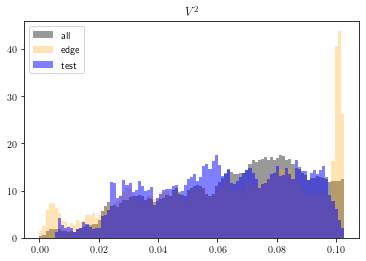

In [30]:
bins_=np.linspace(np.min(z),0.1026,100)
plt.hist(z[z< 0.1026],alpha=0.8,density=True,bins=bins_,label='all',color='gray')
plt.hist(z[edge_vf],bins=bins_,density=True,color='orange',label="edge",alpha=0.3)
plt.hist(z[test],bins=bins_,color='blue',density=True,label="test", alpha =0.5)

plt.legend()
plt.title(r"$V^{2}$")
plt.show()

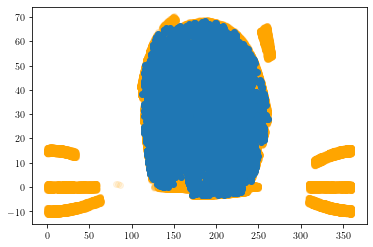

In [31]:
plt.scatter(ra[z< 0.1026], dec[z< 0.1026], color='orange', alpha=0.1)
plt.scatter(ra[test],dec[test])


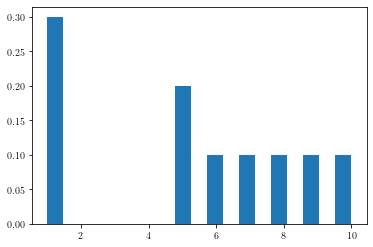

In [309]:
counts, bins = np.histogram([1,1,1,5,5,6,7,8,9,10], np.linspace(1,10, 20))
counts = np.array(counts)/ len(arr)
plt.hist(bins[:-1], bins, weights=counts)
plt.show()

In [767]:
# ax = plt.figure(figsize=(8,4))
# all = Mstar[data['redshift']< 0.1026]
# counts_wall, bins_wall = np.histogram(Mstar[wall_vf], np.linspace(5.5,12.5, 250))
# counts_void, bins_void = np.histogram(Mstar[void_vf], np.linspace(5.5,12.5, 250))
# counts_all, bins_all = np.histogram(all, np.linspace(5.5,12.5, 250))

# counts_wall,counts_void,counts_all = np.array(counts_wall)/ len(Mstar[wall_vf]),np.array(counts_void)/ len(Mstar[void_vf]),np.array(counts_all)/ len(all)
# # plt.hist(bins_wall[:-1], bins=bins_wall, weights=counts_wall)
# # plt.hist(bins_all[:-1], bins=bins_all, weights=counts_void)
# # plt.hist(bins_all[:-1], bins=bins_all, weights=counts_all)

# ax.plt.hist(bins_wall[:-1], bins=bins_wall, weights=counts_wall, label = 'Wall' , color='black', histtype='step')
# ax.hist(bins_void[:-1], bins=bins_void, weights=counts_void ,label = 'Void', color = 'red',histtype='step')
# ax.hist(bins_all[:-1], bins=bins_all, weights=counts_all,  label = 'All', color = 'gray',alpha = 0.3)
# ax.title('Star Mass - Voidfinder')
# ax.ylabel(r"$\frac{count}{total}=$ (Fraction)",fontsize=16)
# ax.legend()
# ax.show()

In [7]:
# def CDF(char_, bins_, title='galaxy property', label='x-label'):
#     '''
#     Plots the cumulative distribution for void,wall galaxies for both algorithms for a given galaxy property
    
#     arguments:
    
#     char_ : (numpy array) charachteristic of galaxy desired for plotting
#     bins_ : (numpy linear space) histogram bins
#     '''

#     fig, ax = plt.subplots(figsize=(20, 6))

#     ax.hist(char_[void_vf].flatten(), bins=bins_, density=True, histtype='step', label='VoidFinder Void', cumulative=True, color='red')
#     ax.hist(char_[wall_vf].flatten(), bins=bins_, density=True, histtype='step', label='VoidFinder Wall',cumulative=True, color='red',linestyle='-.')
#     ax.hist(char_[void_v2], bins=bins_, density=True, histtype='step', label= r'$V^{2}$ Void',cumulative=True, color='blue')
#     ax.hist(char_[wall_v2], bins=bins_, density=True, histtype='step', label= r'$V^{2}$ Wall',cumulative=True,linestyle='-.', color='blue')
#     ax.hist(char_[data['redshift']< 0.1026], bins=bins_, density=True, histtype='step', label='All galaxies',cumulative=True, color='gray')

#     ax.grid(True)
#     ax.legend(loc='upper right',fontsize=18)
# #     ax.set_title(title)
#     ax.set_xlabel(label,fontsize=20)
#     ax.set_ylabel('Likelihood of occurrence',fontsize=20)

#     if label == 'Absolute Magnitude' or label == 'Absolute Magnitude - NSA':
#         ax.set_xlim(-12, -24) 
        
# #     plt.savefig('figures/'+title+".png")
#     plt.show()

#### Star Mass

In [8]:
# def scott_bin_width(data, return_bins=False):
#     """
#         Scott's rule is a normal reference rule: it minimizes the integrated
#     mean squared error in the bin approximation under the assumption that the
#     data is approximately Gaussian.
#     """
#     data = np.asarray(data)
#     if data.ndim != 1:
#         raise ValueError("data should be one-dimensional")

#     n = data.size
#     sigma = np.std(data)
#     dx = 3.5 * sigma / (n ** (1 / 3))
#     if return_bins:
#         Nbins = np.ceil((data.max() - data.min()) / dx)
#         Nbins = max(1, Nbins)
#         bins = data.min() + dx * np.arange(Nbins + 1)
#         return dx, bins
#     else:
#         return dx

In [9]:
# def freedman_bin_width(data, return_bins=False):
#     """
#         The Freedman-Diaconis rule is a normal reference rule like Scott's
#     rule, but uses rank-based statistics for results which are more robust
#     to deviations from a normal distribution.
    
#     """
#     data = np.asarray(data)
#     if data.ndim != 1:
#         raise ValueError("data should be one-dimensional")

#     n = data.size
#     if n < 4:
#         raise ValueError("data should have more than three entries")

#     v25, v75 = np.percentile(data, [25, 75])
#     dx = 2 * (v75 - v25) / (n ** (1 / 3))
#     if return_bins:
#         dmin, dmax = data.min(), data.max()
#         Nbins = max(1, np.ceil((dmax - dmin) / dx))
#         try:
#             bins = dmin + dx * np.arange(Nbins + 1)
#         except ValueError as e:
#             if 'Maximum allowed size exceeded' in str(e):
#                 raise ValueError(
#                     'The inter-quartile range of the data is too small: '
#                     'failed to construct histogram with {} bins. '
#                     'Please use another bin method, such as '
#                     'bins="scott"'.format(Nbins + 1))
#             else:  # Something else  # pragma: no cover
#                 raise
#         return dx, bins
#     else:
#         return dx

In [10]:
# class _KnuthF:
#     r"""Class which implements the function minimized by knuth_bin_width
# """
#     def __init__(self, data):
#         self.data = np.array(data, copy=True)
#         if self.data.ndim != 1:
#             raise ValueError("data should be 1-dimensional")
#         self.data.sort()
#         self.n = self.data.size

#         # import here rather than globally: scipy is an optional dependency.
#         # Note that scipy is imported in the function which calls this,
#         # so there shouldn't be any issue importing here.
#         from scipy import special

#         # create a reference to gammaln to use in self.eval()
#         self.gammaln = special.gammaln

#     def bins(self, M):
#         """Return the bin edges given a width dx"""
#         return np.linspace(self.data[0], self.data[-1], int(M) + 1)

#     def __call__(self, M):
#         return self.eval(M)

#     def eval(self, M):
#         """Evaluate the Knuth function

#         Parameters
#         ----------
#         dx : float
#             Width of bins

#         Returns
#         -------
#         F : float
#             evaluation of the negative Knuth likelihood function:
#             smaller values indicate a better fit.
#         """
#         M = int(M)

#         if M <= 0:
#             return np.inf

#         bins = self.bins(M)
#         nk, bins = np.histogram(self.data, bins)

#         return -(self.n * np.log(M) +
#                  self.gammaln(0.5 * M) -
#                  M * self.gammaln(0.5) -
#                  self.gammaln(self.n + 0.5 * M) +
#                  np.sum(self.gammaln(nk + 0.5)))

# def knuth_bin_width(data, return_bins=False, quiet=True):
#     r"""Return the optimal histogram bin width using Knuth's rule.

#     Knuth's rule is a fixed-width, Bayesian approach to determining
#     the optimal bin width of a histogram.
# """

#     # import here because of optional scipy dependency
#     from scipy import optimize

#     knuthF = _KnuthF(data)
#     dx0, bins0 = freedman_bin_width(data, True)
#     M = optimize.fmin(knuthF, len(bins0), disp=not quiet)[0]
#     bins = knuthF.bins(M)
#     dx = bins[1] - bins[0]

#     if return_bins:
#         return dx, bins
#     else:
#         return dx

In [11]:
# scott_bin_width(Mstar[np.logical_not(np.isnan(Mstar))] )

In [12]:
# freedman_bin_width(Mstar[np.logical_not(np.isnan(Mstar))] )

In [13]:
# knuth_bin_width(Mstar[np.logical_not(np.isnan(Mstar))] )

In [14]:
# np.linspace(5.5,12.5, 155)[-4]-np.linspace(5.5,12.5, 155)[-5]

## Result plots

In [19]:
def char_void(char_, bins_, title='galaxy property', label='x-label'):
    '''
    Plots a histogram for a galaxy charachterstic for void galaxies only for both algorithms
    
    arguments:
    
    char_ : (numpy array) charachteristic of galaxy desired for plotting
    bins_ : (numpy linear space) histogram bins
    '''
    char_void_vf = char_[void_vf]
    char_void_v2 = char_[void_v2]
    
    fig, ax = plt.subplots(figsize=(10, 6)) # 8,4
    
#     plt.hist(char_void_vf, label = 'Voidfinder void galaxies' ,bins= bins_,alpha = 0.6, density = True, color='green')
#     plt.hist(char_void,  label = 'V^2 void galaxies',bins= bins_, color = 'blue',alpha = 0.4, density = True)
#     plt.hist(char_[data['redshift']< 0.1026],  label = 'All galaxies',bins= bins_, color = 'gray',alpha = 0.6, density = True)

#     plt.legend()
#     plt.title(title)
#     plt.xlabel(label)    
    
#     plt.savefig('figures/'+title+".png")
#     plt.show()
    
    
    counts_void_vf, bins_void_vf = np.histogram(char_void_vf, bins= bins_)
    counts_void_v2, bins_void_v2 = np.histogram(char_void_v2, bins= bins_)
    counts_all, bins_all = np.histogram(char_[data['redshift']< 0.1026], bins= bins_)
    
    counts_void_vf,counts_void_v2 = np.array(counts_void_vf)/len(char_void_vf), np.array(counts_void_v2)/len(char_void_v2)
    counts_all = np.array(counts_all)/len(char_[data['redshift']< 0.1026])
    
    ax.hist(bins_void_vf[:-1], bins=bins_void_vf, weights=counts_void_vf, label = 'Voidfinder void galaxies' , color='red', histtype='step')
    ax.hist(bins_void_v2[:-1], bins=bins_void_v2, weights=counts_void_v2 ,label = r'$V^{2}$ void galaxies', color = 'blue',histtype='step')
    ax.hist(bins_all[:-1], bins=bins_all, weights=counts_all,  label = 'All', color = 'gray',alpha = 0.2)
    
    
    ax.legend(fontsize=14)
#     plt.title(title, fontsize=18)
    ax.set_xlabel(label, fontsize=20)
    ax.set_ylabel(r"Fraction of galaxies",fontsize=20)
    
    if label == 'Absolute Magnitude' or label == 'Absolute Magnitude - NSA':
        ax.set_xlim(-12, -24) 
        
#     plt.savefig('figures/'+title+".png")
    plt.show()

In [22]:
def char(char_, bins_, title='galaxy property', label='x-label', voidfinder=False,x=None,y=None):
    '''
    Plots a histogram for a galaxy charachterstic for wall and void galaxies
    
    arguments:
    
    char_ : (numpy array) charachteristic of galaxy desired for plotting
    bins_ : (numpy linear space) histogram bins
    voidfinder : (bool) True if the classification comes from the voidfinder algorithm, False if it comes from V^2
    x: x coordinate of the location of the algorithm's name 
    y: y coordinate of the location of the algorithm's name
    '''
    if voidfinder == True:
        char_wall = char_[wall_vf]
        char_void = char_[void_vf]
#         char_edge = char_[edge_vf]
#         char_out = char_[out_vf]
        x_vf=x
        y_vf=y
    else:
        char_wall = char_[wall_v2]
        char_void = char_[void_v2]
#         char_edge = char_[edge_v2]
#         char_out = char_[out_v2]
        x_v2=x
        y_v2=y
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.tick_params(labelsize=20)
    
    counts_wall, bins_wall = np.histogram(char_wall, bins= bins_)
    counts_void, bins_void = np.histogram(char_void, bins= bins_)
    
#     counts_edge, bins_edge = np.histogram(char_edge, bins= bins_)
#     counts_out, bins_out = np.histogram(char_out, bins= bins_)
    
    counts_all, bins_all = np.histogram(char_[data['redshift']< 0.1026], bins= bins_)
    
    
    counts_wall,counts_void = np.array(counts_wall)/len(char_wall), np.array(counts_void)/len(char_void)
#     counts_edge, counts_out = np.array(counts_edge)/len(char_edge), np.array(counts_out)/len(char_out)
    counts_all = np.array(counts_all)/len(char_[data['redshift']< 0.1026])

    color_wall='blue'
    color_void='green'
    if voidfinder ==True:
        color_wall='black'
        color_void='red'

    ax.hist(bins_wall[:-1], bins=bins_wall, weights=counts_wall, label = 'Wall' , color=color_wall, histtype='step',linestyle=('dashed'))
    ax.hist(bins_void[:-1], bins=bins_void, weights=counts_void ,label = 'Void', color = color_void,histtype='step')
    
#     ax.hist(bins_edge[:-1], bins=bins_edge, weights=counts_edge ,label = 'Edge', color = 'green',histtype='step')
#     ax.hist(bins_out[:-1], bins=bins_out, weights=counts_out ,label = 'Out', color = 'purple',histtype='step')

    ax.hist(bins_all[:-1], bins=bins_all, weights=counts_all,  label = 'All', color = 'gray',alpha = 0.2)
    
#     if (voidfinder == True) & (x!= None):
#         ax.text(x_vf, y_vf, "VoidFinder", fontsize=20)
#     if (voidfinder == False) & (x!= None):
#         ax.text(x_v2, y_v2, r'\boldmath$V^{2}$', fontsize=20)
    
    ax.legend(fontsize=18)
#     plt.title(title, fontsize=18)
    ax.set_xlabel(label, fontsize=24)
    ax.set_ylabel(r"Fraction of galaxies",fontsize=24)
    
    if label == 'Absolute Magnitude' or label == 'Absolute Magnitude - NSA':
        ax.set_xlim(-12, -24) 
    
#     plt.savefig('figures/'+title+".pdf", format='pdf')
    plt.show()
    
    


In [16]:
# make axis ticks numbers larger , "at least" as large as the figure caption
# try different bin sizes , widen a little? double?
# Wall line = dashed / try filling both wall and void / line size on wall thicker than line size in void -- distinguish in Black white
#axis limits to where data is
# should we include CDFs? maybe not (no KS)
# color and linestyle for each class (V2 wall, void , VF void, wall) = 4 colors, 2 linestyles
# Msun - $M_{\odot}$ , Mstar
# log Mstar/Mdot aboe
# unbold axis titles
# serif font , same font throughout plot
# x,y axis ranges accross parameters
# save in eps

In [17]:
# np.linspace(5.9,12, 155)[-1]-np.linspace(5.9,12, 135)[-2]

In [18]:
# char(Mstar,np.linspace(5.9,12, 135),r'Star Mass - Voidfinder',r'$\log(M_*/M_\odot)$', voidfinder = True,x=6,y=0.025)
# char(Mstar,np.linspace(5.9,12, 135),r'Star Mass - Voidfinder',r'$\log(M_*/M_\odot)$',x=6,y=00.025)


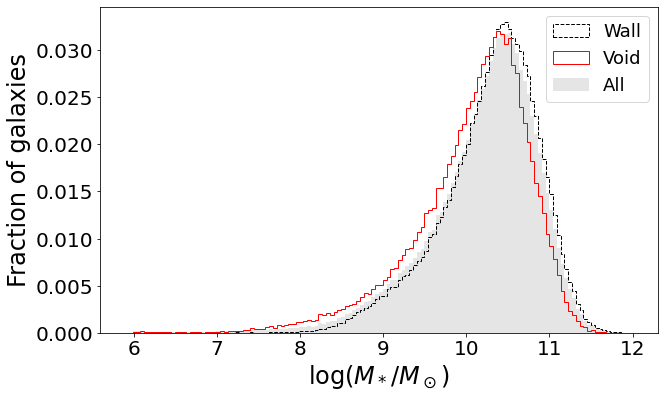

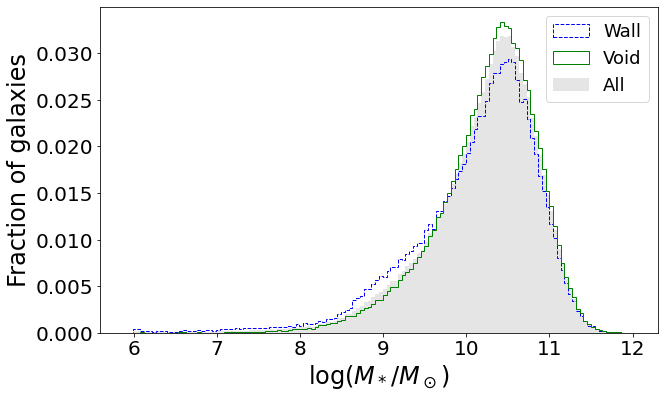

In [23]:
# char_inside(Mstar,np.linspace(5.5,12.5, 250),len(ind_gal_depth_voidv2_new),r'\textbf{Star Mass - }\boldmath${V^{2}}$',r'\boldmath$M_{star} [ log(M_{sun}) ]$',x=6,y=0.019)
# char(Mstar,np.linspace(5.9,12, 135),r'Star Mass - Voidfinder',r'$\log(M_*/M_\odot)$', voidfinder = True,x=6,y=0.025)
char(Mstar,np.linspace(5.9,12, 135),r'Star Mass - Voidfinder',r'$\log(M_*/M_\odot)$',voidfinder=True,x=6,y=00.025)
char(Mstar,np.linspace(5.9,12, 135),r'Star Mass - Voidfinder',r'$\log(M_*/M_\odot)$',x=6,y=00.025)

# char(np.log10(Mstar_NSA),np.linspace(5.9,12, 135),r'Star Mass - Voidfinder',r'$\log(M_*/M_\odot)$',voidfinder=True,x=6,y=00.025)
# char(np.log10(Mstar_NSA),np.linspace(5.9,12, 135),r'Star Mass - Voidfinder',r'$\log(M_*/M_\odot)$',x=6,y=00.025)

# char_void(Mstar,np.linspace(5.5,12.5, 250),'Star Mass - void galaxies',r'\boldmath$Mstar [log(M_{sun})]$')
# CDF(Mstar,np.linspace(5.5,12.5, 700),'Cumulative Star Mass',r'\boldmath$Mstar [log(M_{sun})]$')



In [309]:
Mstar_nan = remove_nan(Mstar)
Mstar_nan_NSA = remove_nan(Mstar_NSA)

In [310]:
len(Mstar_nan_NSA),len(Mstar_nan)

(108213, 646416)

In [58]:
Mstar_nan=np.nan_to_num(Mstar, copy=True, nan=0.0, posinf=0, neginf=0)

In [82]:
bump_1= np.argwhere(Mstar_nan<9.5)
bump_2= np.argwhere(Mstar_nan>8.7)

In [157]:
test=np.intersect1d(np.argwhere(Mstar_nan>9.7),np.argwhere(Mstar_nan<10.5))

In [160]:
test_=random.sample(list(test),35526)
len(test_)

35526

In [84]:
bump_mstar_index = np.intersect1d(bump_1,bump_2)

In [111]:
len(bump_mstar_index) # the indices of galaxies whose mass is between 9.5 and 8.7

35526

In [114]:
len(np.intersect1d(bump_mstar_index, void_v2)), len(np.intersect1d(bump_mstar_index, wall_v2))

(19042, 12884)

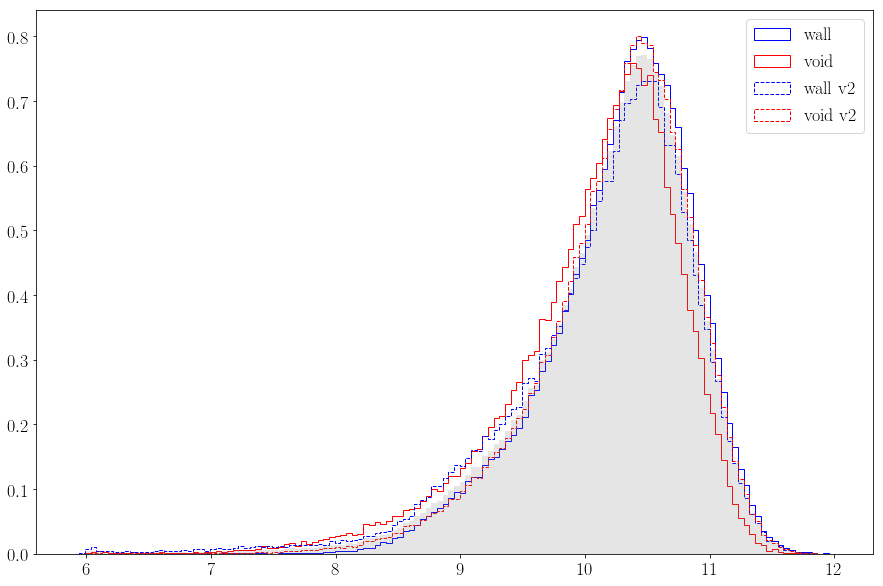

In [258]:
fig = plt.figure(figsize=(15,10))
# plt.hist(Mstar_nan[np.array(data['flag_voidfinder'])==9], bins=np.linspace(5.9,12, 135), label="outside",histtype='step', color="black", density=True)
plt.hist(Mstar_nan[np.array(data['flag_voidfinder'])==0], bins=np.linspace(5.9,12, 135), label="wall",histtype='step', color="blue",density=True)
# plt.hist(Mstar_nan[np.array(data['flag_voidfinder'])==2], bins=np.linspace(5.9,12, 135), label="edge",histtype='step', color="purple",density=True)
plt.hist(Mstar_nan[np.array(data['flag_voidfinder'])==1], bins=np.linspace(5.9,12, 135), color="red",label="void", histtype='step',density=True)

# plt.hist(Mstar_nan[np.array(data['flag_vsquared'])==9], bins=np.linspace(5.9,12, 135), label="outside v2",linestyle=('dashed'),histtype='step', color="black",density=True)
plt.hist(Mstar_nan[np.array(data['flag_vsquared'])==0], bins=np.linspace(5.9,12, 135), label="wall v2",linestyle=('dashed'),histtype='step', color="blue",density=True)
# plt.hist(Mstar_nan[np.array(data['flag_vsquared'])==2], bins=np.linspace(5.9,12, 135), label="edge v2",linestyle=('dashed'),histtype='step', color="purple",density=True)
plt.hist(Mstar_nan[np.array(data['flag_vsquared'])==1], bins=np.linspace(5.9,12, 135), color="red",linestyle=('dashed'),label="void v2", histtype='step',density=True)

plt.hist(Mstar_nan[data['redshift']< 0.1026], bins=np.linspace(5.9,12, 135), color = 'gray',alpha = 0.2,density=True)
plt.legend()
plt.show()

In [110]:
#wall=0 , void = 1, edge= 2, out = 9
print("wall")
print(np.sum(np.array(data['flag_voidfinder'][bump_mstar_index])==0)- np.sum(np.array(data['flag_vsquared'][bump_mstar_index])==0))
print("void")
print(np.sum(np.array(data['flag_voidfinder'][bump_mstar_index])==1)- np.sum(np.array(data['flag_vsquared'][bump_mstar_index])==1))
print("edge")
print(np.sum(np.array(data['flag_voidfinder'][bump_mstar_index])==2)- np.sum(np.array(data['flag_vsquared'][bump_mstar_index])==2))
print("out")
print(np.sum(np.array(data['flag_voidfinder'][bump_mstar_index])==9)- np.sum(np.array(data['flag_vsquared'][bump_mstar_index])==9))


wall
3578
void
-7530
edge
3966
out
-14


In [106]:
np.sum(np.array(data['flag_voidfinder'][bump_mstar_index])==1), np.sum(np.array(data['flag_vsquared'][bump_mstar_index])==1)

(11512, 19042)

In [ ]:
np.sum(np.array(data['flag_voidfinder'][bump_mstar_index])==1), np.sum(np.array(data['flag_vsquared'][bump_mstar_index])==1)

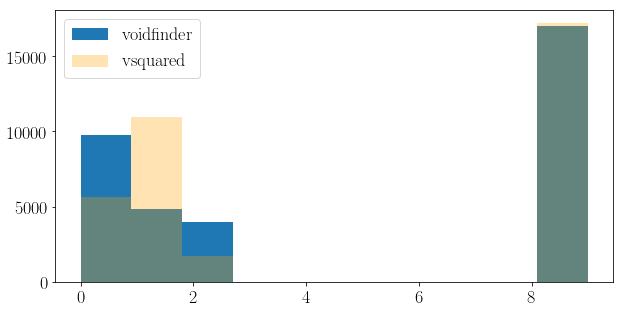

In [291]:
fig = plt.figure(figsize=(10,5))
plt.hist(random.sample(list(data['flag_voidfinder']),35526), label="voidfinder")
plt.hist(random.sample(list(data['flag_vsquared']),35526), color = "orange", alpha=0.3, label="vsquared")
plt.legend()
plt.show()

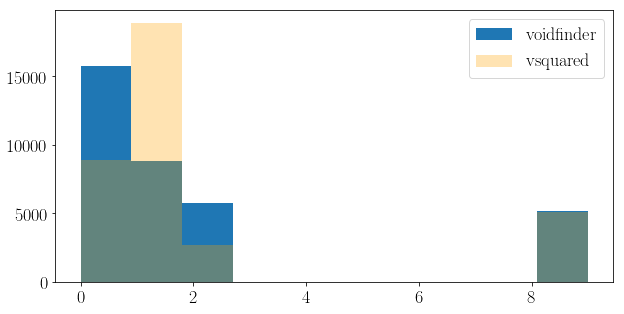

there are much more void galaxies in vsquared than voidfinder in this region


In [292]:
#wall=0 , void = 1, edge= 2, out = 9
fig = plt.figure(figsize=(10,5))
plt.hist(np.array(data['flag_voidfinder'][test_]), label="voidfinder")
plt.hist(np.array(data['flag_vsquared'][test_]), color = "orange", alpha=0.3, label="vsquared")
plt.legend()
plt.show()
print("there are much more void galaxies in vsquared than voidfinder in this region")

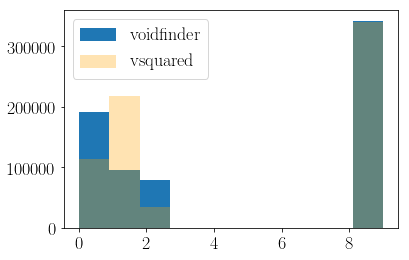

In [165]:
plt.hist(np.array(data['flag_voidfinder']), label="voidfinder")
plt.hist(np.array(data['flag_vsquared']), color = "orange", alpha=0.3, label="vsquared")
plt.legend()

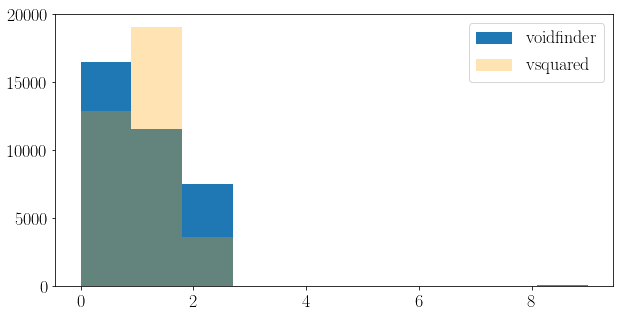

there are much more void galaxies in vsquared than voidfinder in this region


In [290]:
#wall=0 , void = 1, edge= 2, out = 9
fig = plt.figure(figsize=(10,5))
plt.hist(np.array(data['flag_voidfinder'][bump_mstar_index]), label="voidfinder")
plt.hist(np.array(data['flag_vsquared'][bump_mstar_index]), color = "orange", alpha=0.3, label="vsquared")
plt.legend()
plt.show()
print("there are much more void galaxies in vsquared than voidfinder in this region")

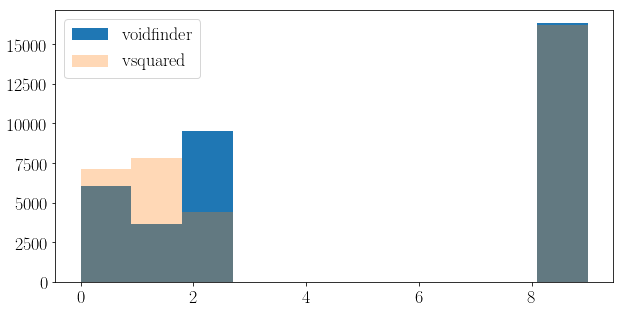

In [133]:
fig = plt.figure(figsize=(10,5))
plt.hist(np.array(data['flag_voidfinder'][35526+35526:35526+35526+35526]), label="voidfinder")
plt.hist(np.array(data['flag_vsquared'][35526+35526:35526+35526+35526]), alpha=0.3, label="vsquared")
plt.legend()
plt.show()

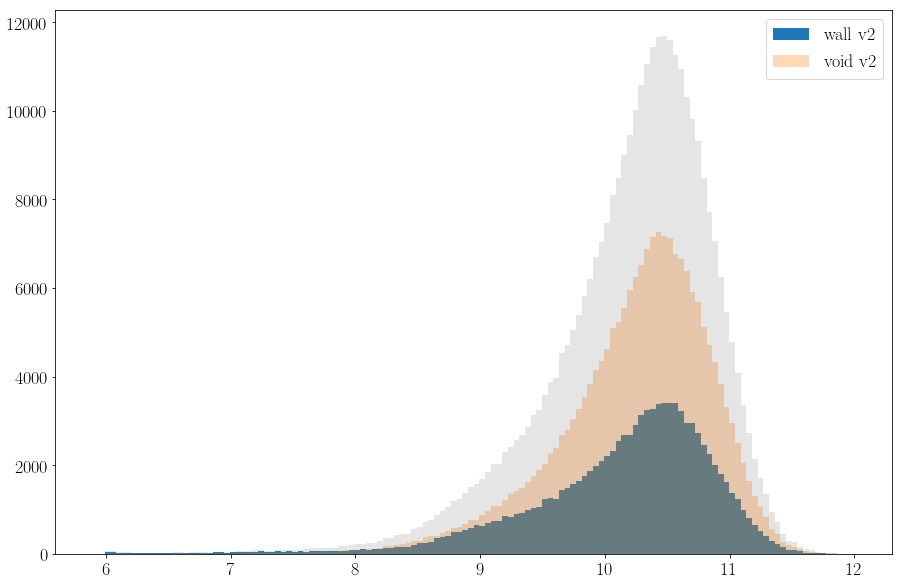

In [214]:
fig = plt.figure(figsize=(15,10))
plt.hist(Mstar_nan[wall_v2], bins=np.linspace(5.9,12, 135), label="wall v2")
plt.hist(Mstar_nan[void_v2], bins=np.linspace(5.9,12, 135), alpha=0.3, label="void v2")
plt.hist(Mstar_nan[data['redshift']< 0.1026], bins=np.linspace(5.9,12, 135), color = 'gray',alpha = 0.2)

plt.legend()
plt.show()

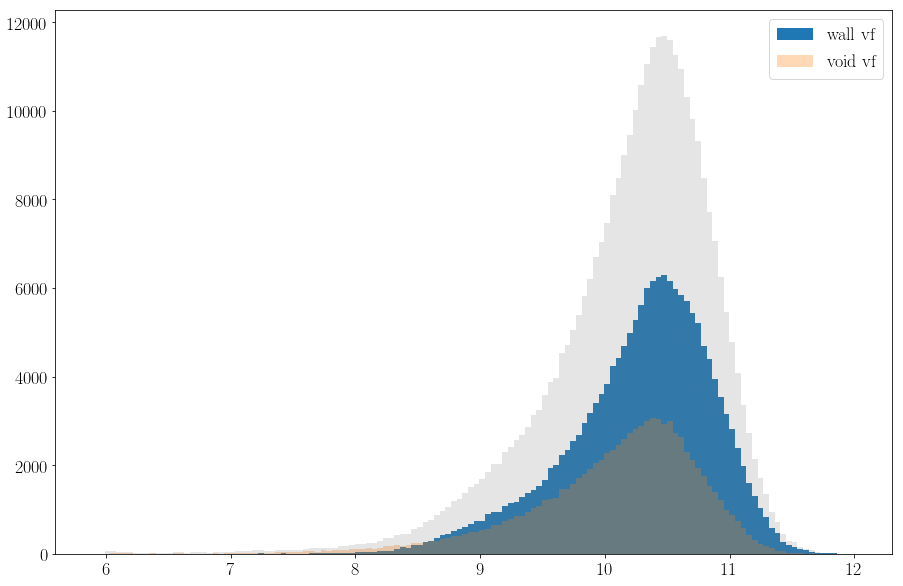

In [253]:
fig = plt.figure(figsize=(15,10))
plt.hist(Mstar_nan[wall_vf], bins=np.linspace(5.9,12, 135), label="wall vf")
plt.hist(Mstar_nan[void_vf], bins=np.linspace(5.9,12, 135), alpha=0.3, label="void vf")
plt.hist(Mstar_nan[data['redshift']< 0.1026], bins=np.linspace(5.9,12, 135), color = 'gray',alpha = 0.2)

plt.legend()
plt.show()

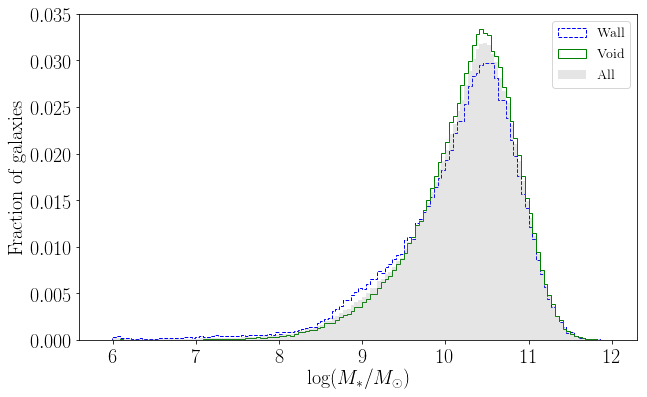

In [62]:
char(Mstar_nan,np.linspace(5.9,12, 135),r'Star Mass - Voidfinder',r'$\log(M_*/M_\odot)$',x=6,y=00.025)


#### Star Mass _ NSA

In [1]:
# char(np.log10(Mstar_NSA),np.linspace(5.5,12.5, 250),r'\textbf{Star Mass NSA - }\boldmath$V^{2}$',r'\boldmath$M_{star-NSA} [log(M_{sun})]$',x=6,y=0.0055)
# char(np.log10(Mstar_NSA),np.linspace(5.5,12.5, 250),'$Star Mass_{NSA} - VoidFinder$',r'\boldmath$M_{star-NSA} [log(M_{sun})]$', voidfinder = True,x=6,y=0.0055)
# char_void(np.log10(Mstar_NSA),np.linspace(5.5,12.5, 250),'$Star Mass_{NSA}- void galaxies$',r'\boldmath$M_{star-NSA} [log(M_{sun})]$')
# CDF(np.log10(Mstar_NSA),np.linspace(5.5,12.5, 700),'$Cumulative Star Mass_{NSA}$',r'\boldmath$M_{star-NSA} [log(M_{sun})]$')

#### Color u_r

In [70]:
# make axis ticks numbers larger , "at least" as large as the figure caption
# try different bin sizes , widen a little? double?
# Wall line = dashed / try filling both wall and void / line size on wall thicker than line size in void -- distinguish in Black white
#axis limits to where data is
# should we include CDFs? maybe not (no KS)
# color and linestyle for each class (V2 wall, void , VF void, wall) = 4 colors, 2 linestyles
# Msun - $M_{\odot}$ , Mstar
# log Mstar/Mdot aboe
# unbold axis titles
# serif font , same font throughout plot
# x,y axis ranges accross parameters
# save in eps

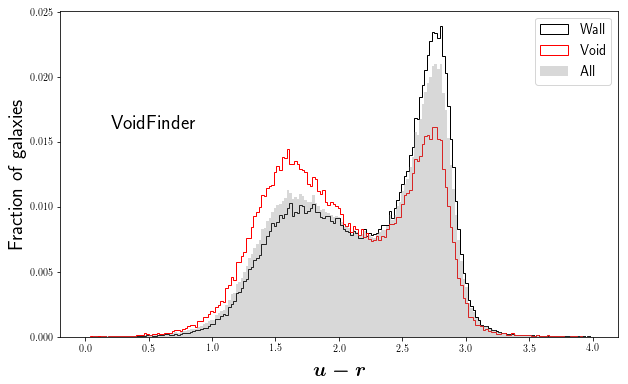

In [42]:
# char(u_r,np.linspace(0,4, 200),'Color u_r - V^2',r'\boldmath$u-r$',x=0.2,y=0.016)
char(u_r,np.linspace(0,4, 200),'Color u_r - Voidfinder',r'\boldmath$u-r$', voidfinder = True,x=0.2,y=0.016)
# char_void(u_r,np.linspace(0,4, 500),'Color u_r - void galaxies',r'\boldmath$u-r$')
# CDF(u_r,np.linspace(0,4, 700),'Cumulative Color u_r',r'\boldmath$u-r$')


#### Color u_r _NSA

In [ ]:
The conclusions from VF are in line with the literature that indicates that void galaxies are retarded in their star formation because they evolve in an environment with fewer interactions (mergers, tidal stripping etc) compared to wall galaxies. 
V2 does not make the same prediction because it grows voids farther into the walls which leads to the contamination of the classification


In [2]:
# char(u_r_NSA,np.linspace(-1,4, 250),'Color u_r V^2',r'\boldmath$u-r$ \textrm{(NSA)}',x=-0.5,y=0.005)
# char(u_r_NSA,np.linspace(-1,4, 250),'Color u_r-NSA- Voidfinder',r'\boldmath$u-r$ \textrm{(NSA)}', voidfinder = True,x=-0.5,y=0.0055)
# char_void(u_r_NSA,np.linspace(-1,4, 250),'Color u_r -NSA- void galaxies',r'\boldmath$u-r$ \textrm{(NSA)}')
# CDF(u_r_NSA,np.linspace(-1,4, 700),'Cumulative Color u_r-NSA',r'\boldmath$u-r$ \textrm{(NSA)}')


#### Color g_r 

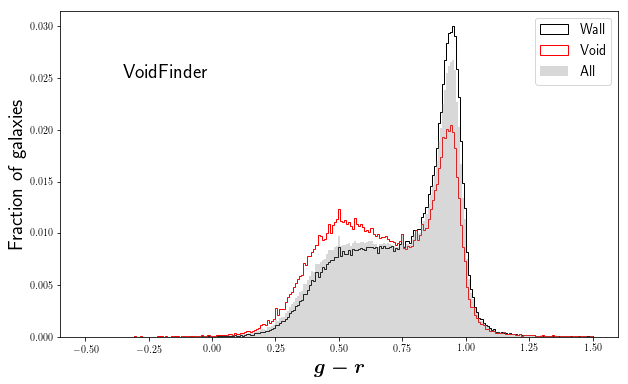

In [43]:
# char_inside(g_r,np.linspace(-0.5,1.5, 250),'Color g_r - V^2',r'\boldmath$g-r$',x=-0.35,y=0.025)
char(g_r,np.linspace(-0.5,1.5, 250),'Color g_r - Voidfinder',r'\boldmath$g-r$', voidfinder = True,x=-0.35,y=0.025)
# char_void(g_r,np.linspace(-0.5,1.5, 250),'Color g_r - void galaxies',r'\boldmath$g-r$')
# CDF(g_r,np.linspace(-0.5,1.5, 700),'Cumulative Color g_r',r'\boldmath$g-r$')

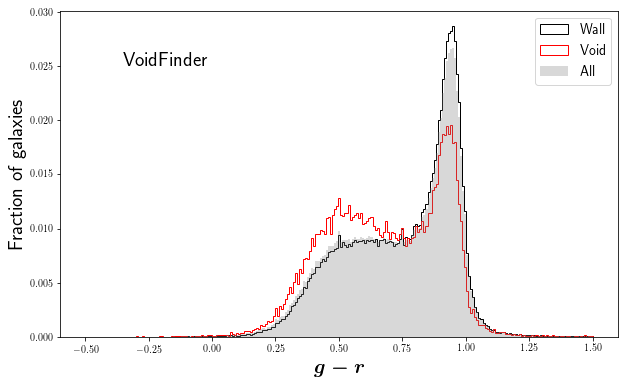

In [17]:
# char(g_r,np.linspace(-0.5,1.5, 250),'Color g_r - V^2',r'\boldmath$g-r$',x=-0.35,y=0.025)
char_inside(g_r,np.linspace(-0.5,1.5, 250),'Color g_r - Voidfinder',r'\boldmath$g-r$', voidfinder = True,x=-0.35,y=0.025)
# char_void(g_r,np.linspace(-0.5,1.5, 250),'Color g_r - void galaxies',r'\boldmath$g-r$')
# CDF(g_r,np.linspace(-0.5,1.5, 700),'Cumulative Color g_r',r'\boldmath$g-r$')

#### Color g_r _NSA

In [3]:
# char(g_r_NSA,np.linspace(-0.5,1.3, 250),'Color g_r-NSA - V^2',r'\boldmath$g-r$ \textrm{(NSA)}',x=-0.35,y=0.0055)
# char(g_r_NSA,np.linspace(-0.5,1.3, 250),'Color g_r-NSA - Voidfinder',r'\boldmath$g-r$ \textrm{(NSA)}', voidfinder = True,x=-0.35,y=0.005)
# char_void(g_r_NSA,np.linspace(-0.5,1.3, 250),'Color g_r -NSA- void galaxies',r'\boldmath$g-r$ \textrm{(NSA)}')
# CDF(g_r_NSA,np.linspace(-0.5,1, 700),'Cumulative Color g_r-NSA',r'\boldmath$g-r$ \textrm{(NSA)}')

#### Absolute magnitude

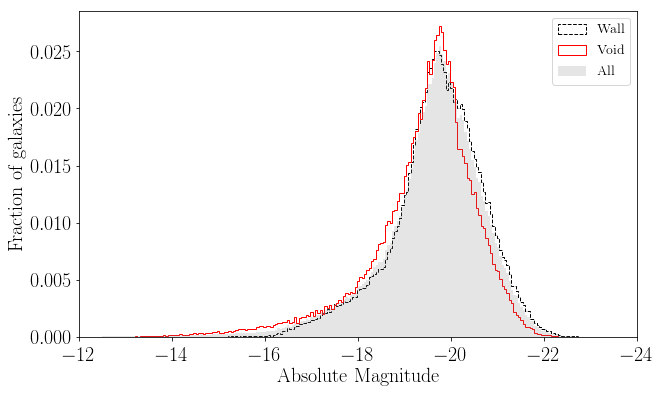

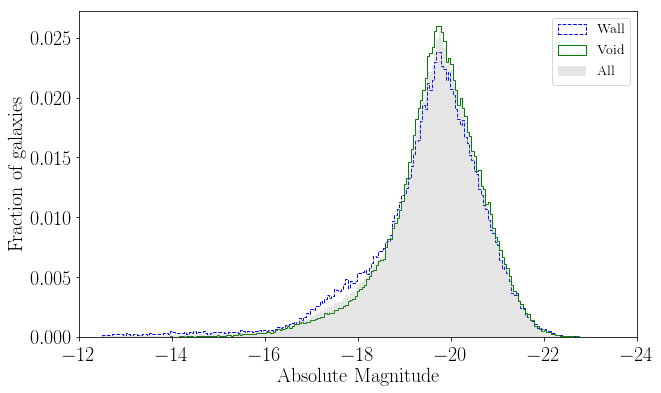

In [295]:
# char_inside(rabsmag,np.linspace(-25,-12.5, 250),'Absolute Magnitude - V^2','Absolute Magnitude',x=-13,y=0.023)
char(rabsmag,np.linspace(-25,-12.5, 250),'Absolute Magnitude - Voidfinder','Absolute Magnitude', voidfinder = True,x=-13,y=0.023)
char(rabsmag,np.linspace(-25,-12.5, 250),'Absolute Magnitude - Voidfinder','Absolute Magnitude',x=-13,y=0.023)
# char_void(rabsmag,np.linspace(-25,-12.5, 250),'Absolute Magnitude- void galaxies','Absolute Magnitude')
# CDF(rabsmag,np.linspace(-25,-12.5, 700),'Cumulative Absolute Magnitude','Absolute Magnitude')

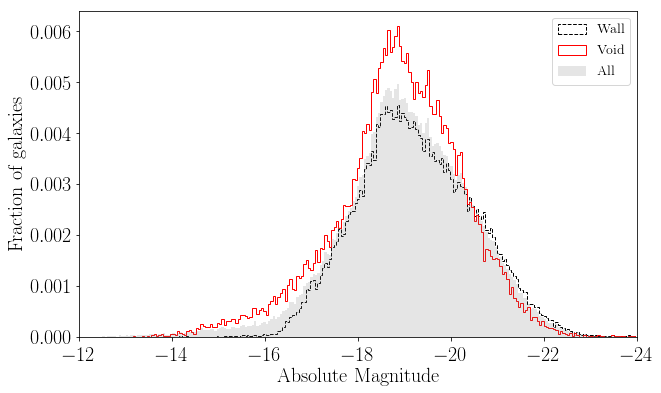

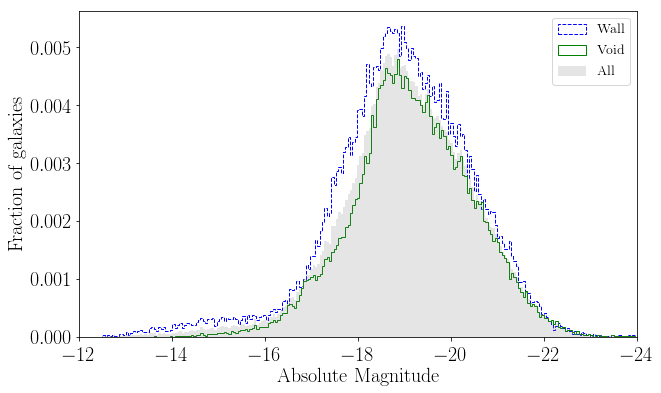

In [297]:
# char_inside(rabsmag,np.linspace(-25,-12.5, 250),'Absolute Magnitude - V^2','Absolute Magnitude',x=-13,y=0.023)
char(rabsmag_NSA,np.linspace(-25,-12.5, 250),'Absolute Magnitude - Voidfinder','Absolute Magnitude', voidfinder = True,x=-13,y=0.023)
char(rabsmag_NSA,np.linspace(-25,-12.5, 250),'Absolute Magnitude - Vsquared','Absolute Magnitude',x=-13,y=0.023)
# char_void(rabsmag,np.linspace(-25,-12.5, 250),'Absolute Magnitude- void galaxies','Absolute Magnitude')
# CDF(rabsmag,np.linspace(-25,-12.5, 700),'Cumulative Absolute Magnitude','Absolute Magnitude')

#### Absolute magnitude _NSA

In [4]:
# char(rabsmag_NSA,np.linspace(-25,-12.5, 250),'Absolute Magnitude_NSA - V^2','Absolute Magnitude - NSA',x=-13,y=0.0052)
# char(rabsmag_NSA,np.linspace(-25,-12.5, 250),'Absolute Magnitude_NSA - Voidfinder','Absolute Magnitude - NSA', voidfinder = True,x=-13,y=0.0052)
# char_void(rabsmag_NSA,np.linspace(-25,-12.5, 250),'Absolute Magnitude_NSA- void galaxies','Absolute Magnitude - NSA')
# CDF(rabsmag_NSA,np.linspace(-25,-12.5, 700),'Cumulative Absolute Magnitude_NSA','Absolute Magnitude - NSA')

#### Star Formation Rate

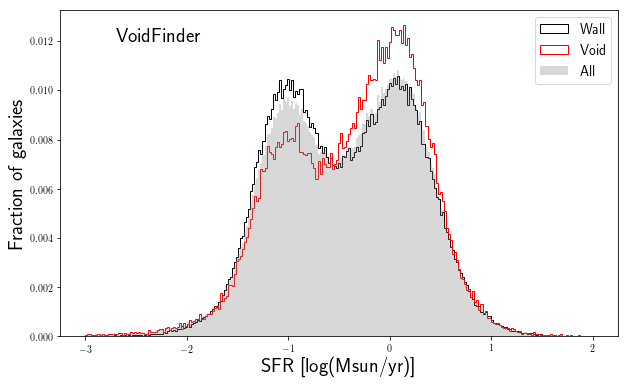

In [45]:
# char_inside(SFR,np.linspace(-3,2, 250),'star formation rate - V^2','SFR [log(Msun/yr)]',x=-2.7,y=0.0105)
char(SFR,np.linspace(-3,2, 250),'star formation rate - Voidfinder','SFR [log(Msun/yr)]', voidfinder = True,x=-2.7,y=0.012)
# char_void(SFR,np.linspace(-3,2, 250),'star formation rate- void galaxies','SFR [log(Msun/yr)]')
# CDF(SFR,np.linspace(-3,2, 700),'Cumulative star formation rate','SFR [log(Msun/yr)]')

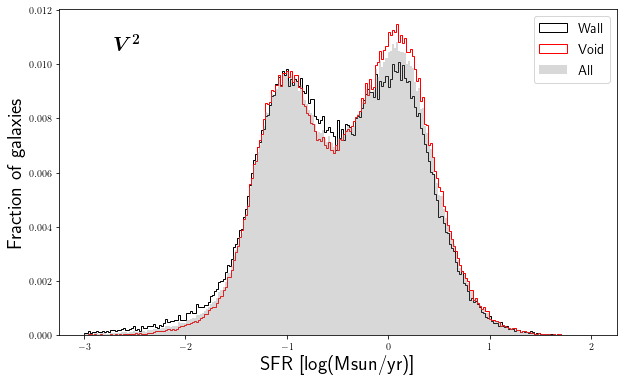

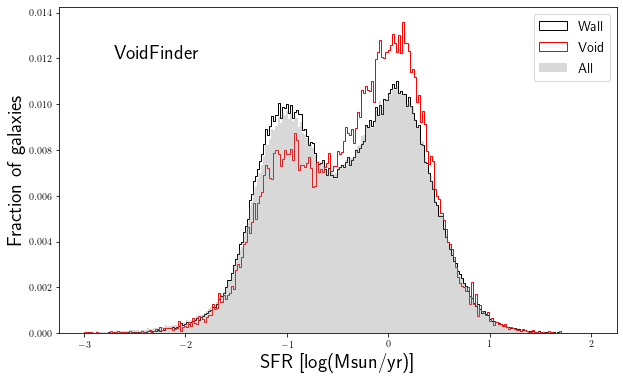

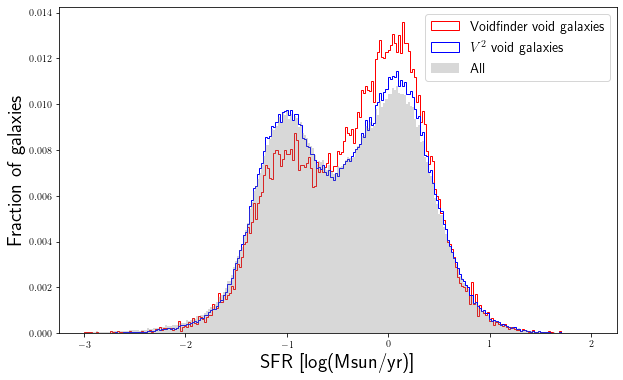

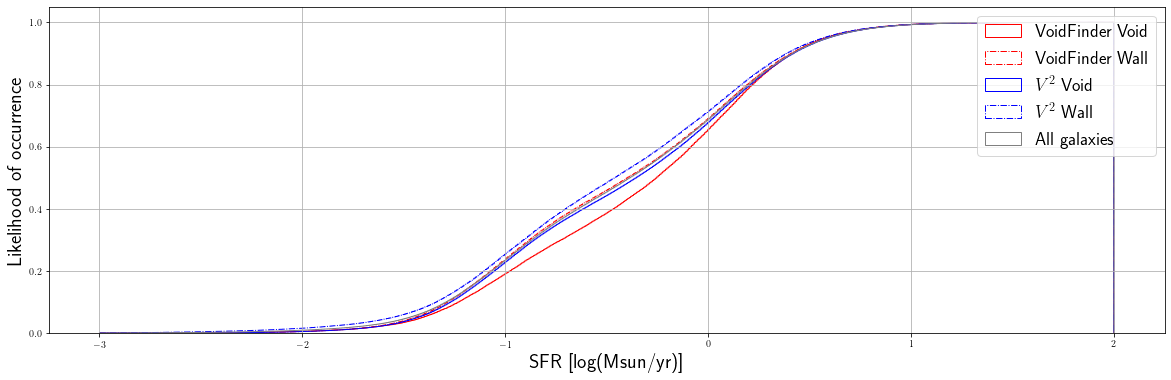

In [15]:
char(SFR,np.linspace(-3,2, 250),'star formation rate - V^2','SFR [log(Msun/yr)]',x=-2.7,y=0.0105)
char(SFR,np.linspace(-3,2, 250),'star formation rate - Voidfinder','SFR [log(Msun/yr)]', voidfinder = True,x=-2.7,y=0.012)
char_void(SFR,np.linspace(-3,2, 250),'star formation rate- void galaxies','SFR [log(Msun/yr)]')
CDF(SFR,np.linspace(-3,2, 700),'Cumulative star formation rate','SFR [log(Msun/yr)]')

#### Specific star Formation Rate

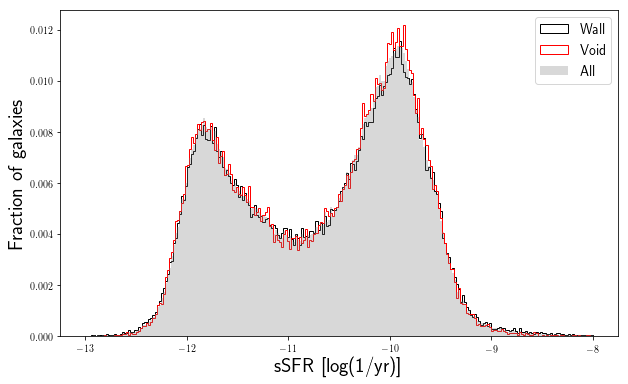

In [82]:
char_inside(sSFR,np.linspace(-13,-8, 250),'specific star formation rate - V^2','sSFR [log(1/yr)] ',x=-12.7,y=0.0105)
# char(sSFR,np.linspace(-13,-8, 250),'specific star formation rate - Voidfinder','sSFR [log(1/yr)]', voidfinder = True,x=-12.7,y=0.013)
# char_void(sSFR,np.linspace(-13,-8, 250),'specific star formation rate- void galaxies','sSFR [log(1/yr)] ')
# CDF(sSFR,np.linspace(-13,-8, 700),'Cumulative specific star formation rate','sSFR [log(1/yr)] ')

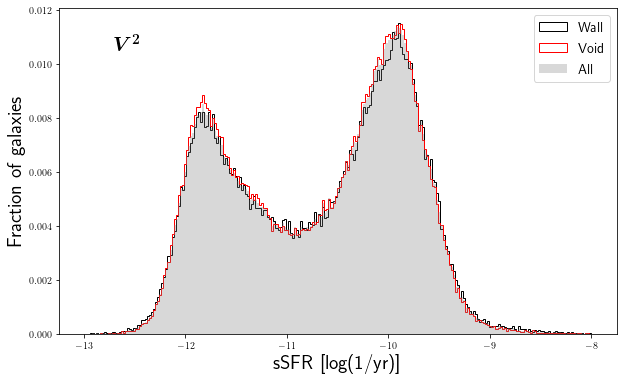

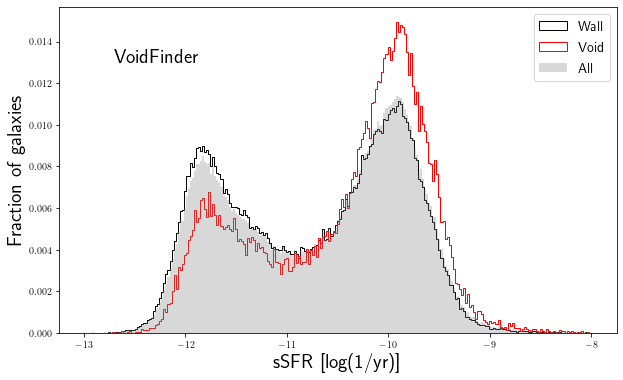

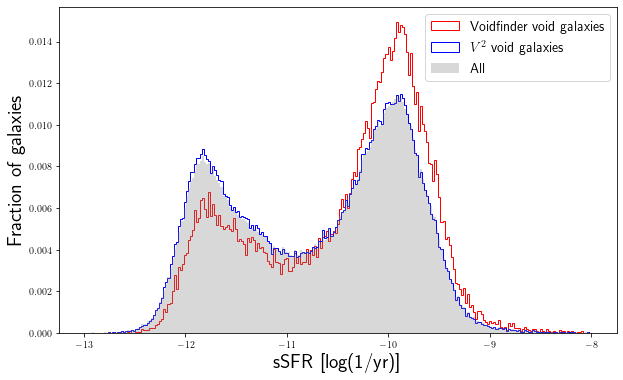

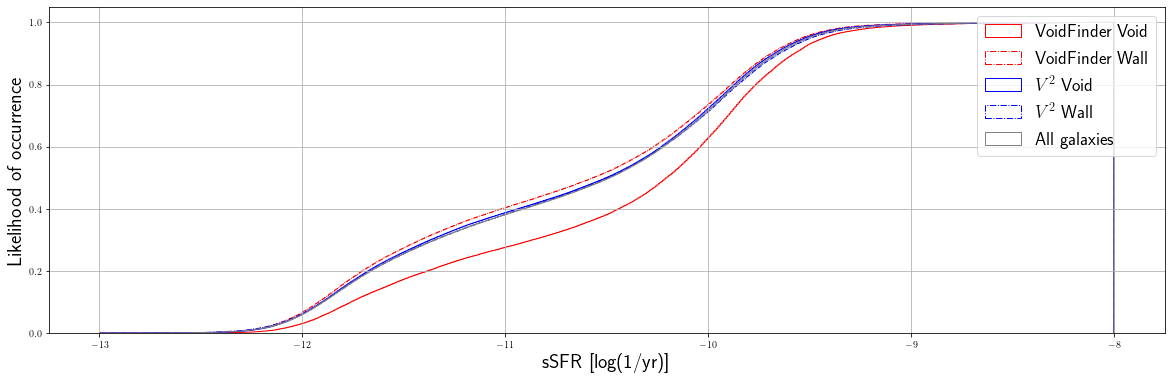

In [18]:
char(sSFR,np.linspace(-13,-8, 250),'specific star formation rate - V^2','sSFR [log(1/yr)] ',x=-12.7,y=0.0105)
char(sSFR,np.linspace(-13,-8, 250),'specific star formation rate - Voidfinder','sSFR [log(1/yr)]', voidfinder = True,x=-12.7,y=0.013)
char_void(sSFR,np.linspace(-13,-8, 250),'specific star formation rate- void galaxies','sSFR [log(1/yr)] ')
CDF(sSFR,np.linspace(-13,-8, 700),'Cumulative specific star formation rate','sSFR [log(1/yr)] ')

### KS tests

In [31]:
def KS(char_, void_void=False,void_wall=False,wall_wall=False,voidfinder=False,v2=False):
    '''
    char_: array of galaxy property
    void_void: True if we want to calculate the KS test between two void galaxy samples
    void_wall: True if we want to calculate the KS test between void and wall galaxy samples
    voidfinder : True only if void_wall is True and classification from voidfinder is used
    '''
    #void_wall
    if (void_wall and voidfinder):
        return stats.ks_2samp(char_[wall_vf], char_[void_vf]) 
    if (void_wall and v2):
        return stats.ks_2samp(char_[wall_v2], char_[void_v2]) 
    
    #void_void
    if void_void:
        return stats.ks_2samp(char_[void_vf], char_[void_v2]) 

    # wall_wall
    if wall_wall:
        return stats.ks_2samp(char_[wall_vf], char_[wall_v2]) 



In [35]:
def KS_table(char_):
    '''
    output: two numbers for each cell: kS Test statistic and p-value
    
    diagonals are void_void and wall_wall, row2col1 is void_wall for voidfinder,  and row1col2 is void_wall for V^2
    '''
    a_1_1 = tuple(KS(char_,void_void=True)) #1_1
    a_2_1 = tuple(KS(char_,void_wall=True,voidfinder=True))

    a_1_2 = tuple(KS(char_,void_wall=True,v2=True))
    a_2_2 = tuple(KS(char_,wall_wall=True)) 

    col1=[a_1_1,a_2_1]
    
    col2=[a_1_2,a_2_2]
    

    
    return Table([col1,col2], names=('voidfinder','v_squared'))


In [56]:
print(stats.ks_2samp(Mstar[void_vf], Mstar[wall_v2]) )
print(stats.ks_2samp(u_r[void_vf], u_r[wall_v2]) )
print(stats.ks_2samp(g_r[void_vf], g_r[wall_v2]) )
print(stats.ks_2samp(rabsmag[void_vf], rabsmag[wall_v2]) )
print(stats.ks_2samp(SFR[void_vf], SFR[wall_v2]) )
print(stats.ks_2samp(sSFR[void_vf], sSFR[wall_v2])) 

Ks_2sampResult(statistic=0.09737432984377059, pvalue=9.596518308845177e-277)
Ks_2sampResult(statistic=0.0974511063843424, pvalue=3.517261688586993e-277)
Ks_2sampResult(statistic=0.09735619756826153, pvalue=1.2162194642940036e-276)
Ks_2sampResult(statistic=0.06347187632710183, pvalue=7.88210948369142e-118)
Ks_2sampResult(statistic=0.09303149284014245, pvalue=1.2017203629488489e-252)
Ks_2sampResult(statistic=0.08821650698776451, pvalue=3.253512720093948e-227)


In [59]:
print(stats.ks_2samp(Mstar[wall_v2], Mstar[wall_vf]) )
print(stats.ks_2samp(u_r[wall_v2], u_r[wall_vf]) )
print(stats.ks_2samp(g_r[wall_v2], g_r[wall_vf]) )
print(stats.ks_2samp(rabsmag[wall_v2], rabsmag[wall_vf]) )
print(stats.ks_2samp(SFR[wall_v2], SFR[wall_vf]) )
print(stats.ks_2samp(sSFR[wall_v2], sSFR[wall_vf])) 

Ks_2sampResult(statistic=0.06905365180479675, pvalue=0.0)
Ks_2sampResult(statistic=0.04061800208835664, pvalue=1.0664370213578124e-116)
Ks_2sampResult(statistic=0.04387652575658352, pvalue=4.2065027361769384e-136)
Ks_2sampResult(statistic=0.09127565178886077, pvalue=0.0)
Ks_2sampResult(statistic=0.03518965229369064, pvalue=1.0705447985007178e-87)
Ks_2sampResult(statistic=0.036294646464199665, pvalue=2.9021058099386363e-93)


In [44]:
KS_table(sSFR)

voidfinder [2],v_squared [2]
float64,float64
0.11063584061143517 .. 0.0,0.03529738868550192 .. 1.2314651729235756e-85
0.1204748760652663 .. 0.0,0.036294646464199665 .. 2.9021058099386363e-93


In [774]:
#void-void      void-wall-v2
#void-wall-vf   wall-wall

In [775]:
# decide how to interpret KS test, compare to critical value, p-value? ...

In [776]:
def critical_value(n,m,alpha=0.000000000000000000000000000000000000000001):
    '''
    calculates critical value: if the test statistic is larger than this then the null hypothesis can be rejected 
    at level alpha.
    n: size of sample 1
    m: size of sample 2
    '''
    
    return np.sqrt(-np.log(alpha/2)*(1/2))*np.sqrt((n+m)/(n*m))

In [595]:
critical_value(len(Mstar[wall_vf]),len(Mstar[void_vf])), critical_value(len(Mstar[wall_v2]),len(Mstar[void_v2]))

(0.035894099904138624, 0.02486973838113133)

In [583]:
critical_value(len(Mstar[data['redshift']< 0.1026]),len(Mstar[void_vf])), critical_value(len(Mstar[data['redshift']< 0.1026]),len(Mstar[void_v2]))

(0.006748918330462532, 0.003741446596947954)

In [ ]:
#next: understand hypothesis testing, what does it mean for the hypothesis to be rejected the X% level?
# write statistics paragraph for stellar mass

### Calculate averages and medians

In [35]:
def remove_nan(array):
    return array[np.logical_not(np.isnan(array))]

In [14]:
def stats(char_,voidfinder =False):
    '''
    char : array with galaxy properties e.g : Mstar
    voidfinder : true if we want to calculate the statistics of voidfinder data and not V^2 data
    
    note 1 : shifts are taken as void-wall
    note 2: percent difference are calculated with respect to the wall distribution
    
    returns: average, std of average, average shift, std of average shift, percent diff of avg , median, median shift, 
    percent diff of median
    '''
    if voidfinder==True:
        char_void= remove_nan(char_[void_vf])
        char_wall=remove_nan(char_[wall_vf])
        
    else:
        char_void= remove_nan(char_[void_v2])
        char_wall=remove_nan(char_[wall_v2])
        
    avg_void = np.mean(char_void)
    avg_wall = np.mean(char_wall)
        
    avg_shift=  avg_wall-avg_void
        
    std_avg_void = np.std(char_void,ddof=1)/np.sqrt(len(char_void))
    std_avg_wall = np.std(char_wall,ddof=1)/np.sqrt(len(char_wall))
    
    std_avg_shift = np.sqrt(std_avg_void**2 + std_avg_wall**2)
        
    percent_diff_avg = (avg_shift/avg_wall)*100
    
    median_wall = np.median(char_wall)
    median_void = np.median(char_void)
    
    median_shift = median_wall-median_void
    
    percent_diff_median = (median_shift/median_wall)*100
    
    print('average void : %f +- %f' %(avg_void, std_avg_void))
    print('average wall :  %f +- %f'%(avg_wall, std_avg_wall))
    print('average shift w.r.t wall :  %f +- %f'%(avg_shift, std_avg_shift))
    print('percent difference in avg w.r.t wall : ', percent_diff_avg)
    print('median void : ', median_void)
    print('median wall : ', median_wall)
    print('median shift w.r.t wall: ', median_shift)
    print('percent difference in median w.r.t wall : ', percent_diff_median)


In [25]:
stats(sSFR, voidfinder=True)


average void : -10.451034 +- 0.003962
average wall :  -10.724633 +- 0.001909
average shift w.r.t wall :  -0.273599 +- 0.004398
percent difference in avg w.r.t wall :  2.5511244529926858
median void :  -10.201032638549805
median wall :  -10.563491821289062
median shift w.r.t wall:  -0.3624591827392578
percent difference in median w.r.t wall :  3.4312440324777658


In [27]:
stats(sSFR)

average void : -10.702911 +- 0.001973
average wall :  -10.652602 +- 0.002572
average shift w.r.t wall :  0.050309 +- 0.003242
percent difference in avg w.r.t wall :  -0.4722709265591281
median void :  -10.517784595489502
median wall :  -10.457787990570068
median shift w.r.t wall:  0.059996604919433594
percent difference in median w.r.t wall :  -0.5737026316992978


In [832]:
stats(sSFR, voidfinder=True)


average void : -10.451034 +- 0.003962
average wall :  -10.724633 +- 0.001909
average shift w.r.t wall :  -0.273599 +- 0.004398
percent difference in avg w.r.t wall :  2.5511244529926858
median void :  -10.201032638549805
median wall :  -10.563491821289062
median shift w.r.t wall:  -0.3624591827392578
percent difference in median w.r.t wall :  3.4312440324777658


In [829]:
stats(SFR)

average void : -0.384173 +- 0.001510
average wall :  -0.509991 +- 0.002095
average shift w.r.t wall :  -0.125818 +- 0.002583
percent difference in avg w.r.t wall :  24.6706388562237
median void :  -0.324832558631897
median wall :  -0.4944124221801758
median shift w.r.t wall:  -0.1695798635482788
percent difference in median w.r.t wall :  34.29927241724518


In [724]:
from pprint import pprint
pprint ([(i, stats.ks_2samp(Mstar[void_vf][:i], Mstar[void_v2][:i])[1]) for i in range(28030,28050,1)])

[(28030, 1e-323),
 (28031, 1e-323),
 (28032, 1e-323),
 (28033, 1e-323),
 (28034, 1e-323),
 (28035, 1e-323),
 (28036, 0.0),
 (28037, 0.0),
 (28038, 0.0),
 (28039, 0.0),
 (28040, 0.0),
 (28041, 0.0),
 (28042, 0.0),
 (28043, 0.0),
 (28044, 0.0),
 (28045, 0.0),
 (28046, 0.0),
 (28047, 0.0),
 (28048, 0.0),
 (28049, 0.0)]


In [731]:
print(len(remove_nan(Mstar)[(remove_nan(Mstar)>10)]))

542611


In [735]:
stats.ks_2samp(Mstar[wall_v2][Mstar[wall_v2]<10], Mstar[void_v2][Mstar[void_v2]<10]) #V^2

Ks_2sampResult(statistic=0.08318112786478526, pvalue=0.0)

In [52]:
from scipy.stats import norm
sigma = norm.isf(10**(-200))

In [53]:
sigma

30.20559417957964